# Optimización del Reemplazo de Flotas de Autobuses Diésel por Eléctricos en Quito: Un Enfoque de Programación Lineal Entera Mixta

## Implementación y Análisis Computacional

### Estéfano Viteri
### Tesis de Maestría en Optimización Matemática
### Escuela Politécnica Nacional
### Agosto 2024

## Introducción

Este cuaderno de Jupyter presenta la implementación del modelo de optimización para el reemplazo de flotas de autobuses diésel por eléctricos en la ciudad de Quito. El objetivo principal es analizar diferentes escenarios y evaluar la viabilidad económica y ambiental del plan de transición.

## Implementación

In [1]:
# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from gurobipy import GRB,Model,quicksum
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Funciones de ayuda
def CD(j):
    return 0.599 + 0.1083*j

def ide(k,K_E,K_R,PD,PE_N,PE_D,rho_N):
        if k in K_R:
            return (rho_N * PE_N + (1-rho_N)*PE_D)
        elif k in K_E:
            return PE_N
        else:
            return PD

def tam_bat(i,K_E):
        if i in K_E:
            return int(i.split('_')[3])
        else:
            return 0

In [3]:
def crear_input(datos,params):
    # Parametros generales

    t1      = 2025   # Periodo inicial
    num_per = params['Periodos']#int(param['Cantidad de periodos']) # incluido el inicial
    dr      = 0.03   # Tasa de descuento anual
    beta    = 1/(1 + dr)
    Gamma   = 7.5 # Promedio de vida maxima final años
    F       = 52.8 # Cargos por demanda al año (USD por kW)
    B       = params['presupuesto'][1] if params['presupuesto'][0] else 0 # Presupuesto
    T       = range(t1,t1 + num_per)
    t_F     = t1 + num_per - 1
    # Si t1 = 2025 y num_per = 6, entonces T = [2025, 2026, 2027, 2028, 2029, 2030] y T_f = 2030
    
    '''*********************************************************************************'''
    
    # Estado actual de la flota
    buses     = datos['Buses']
    K         = list(buses['Codigo']) # Tipos de buses
    K_E       = [i for i in K if '_EB_' in i] # Tipos de buses eléctricos
    K_R       = [i for i in K if '_EB_' in i and 'CT' in i] # Tipos de buses eléctricos
    J_K       = {i[0]: range(0,i[1]+1) for i in buses[['Codigo','Vida útil (años)']].values} # Vida útil (años)
    mc        = {(i[0],t): i[1] for i in buses[['Codigo','Costo de media vida']].values for t in T} # Costo media vida
    alpha     = {i[0]: i[1] for i in buses[['Codigo','Media vida (años)']].values} # Edad de media vida
    kappa     = {i[0]: i[1] - 1 for i in buses[['Codigo','Vida útil (años)']].values} # Edad máxima o períodos máximos de circulación
    J_K_tilde = {i: [a for a in j if a != (kappa[i]+1)]  for i,j in J_K.items()}
    tipo_bus  = {i[0]: i[1] for i in buses[['Codigo','Tipo']].values} # Eléctrico (EB) o a Diesel (Diesel)
    efic_bus  = {i[0]: i[1] for i in buses[['Codigo','Eficiencia de combustible (km/combustible)']].values} # Eficiencia (km/combustible)
    cost_ini_bus  = {i[0]: i[1] for i in buses[['Codigo','Costo de compra (USD)']].values} # Costo de compra inicial (USD)

    # Edad flota y precios de salvamento
    flota = datos['Flota'].set_index('Edad')
    salva = datos['Flota salvamento'].set_index('Edad')
    a = {(j,i): val if val > 0 else 0 for j in flota.columns for i, val in flota[j].items() } # (bus,edad): # buses
    s = {(j,i): val if val > 0 else 0 for j in salva.columns for i, val in salva[j].items() } # (bus,edad): precio venta
    
    '''*********************************************************************************'''
    
    # Información Cargadores
    carg    = datos['Cargadores']
    CT      = list(carg['Codigo']) # Tipos de cargadores
    c_tilde = [a for a in CT if 'Pila' in a][0] # Cargador tipo Pila
    e       = {i[0]: i[1] for i in carg[['Codigo','Inventario']].values} # Cargadores iniciales
    p       = {i[0]: i[1] for i in carg[['Codigo','Costo de compra (USD)']].values} # Costo de compra por unidad de cargador (USD)
    g       = {i[0]: i[1] for i in carg[['Codigo','Potencia de carga (kW)']].values} # Potencia de carga (kW)
    theta   = {i[0]: int(i[1].split(':')[1])/int(i[1].split(':')[0]) if 'o' not in i[1] else 0 for i in carg[['Codigo','Relacion bus-cargador']].values} # Relación bus-cargador
    cont    = datos['Contenedor'] # se asume tener solo un tipo de contenedor
    id_cont = cont['Codigo'][0] # Codigo del contenedor
    e_tilde = cont['Inventario'][0] # Contenedores iniciales
    p_tilde = cont['Costo de compra (USD)'][0] # Costo contenedor
    theta_tilde =  int(cont['Relacion contenedor-pila'][0].split(':')[1]) # Capacidad contenedor

    '''*********************************************************************************'''
    
    # Compatibilidades bus-cargador y bus-ruta

    comp_bus_carg = datos['Compat buses-cargadores'].set_index('Cargadores\n          Buses')
    comp_bus_rut = datos['Compat buses-rutas'].set_index('Buses\n          Rutas')

    # Cargadores factibles para cada tipo de bus
    C     = {i: [j for j in comp_bus_carg.columns if comp_bus_carg.at[i,j] == 'x'] for i in comp_bus_carg.index} # {bus:[cargadores]}
    # Rutas factibles para cada tipo de bus
    h_aux = {j: [i for i, val in comp_bus_rut[j].items() if val == 'x'] for j in comp_bus_rut.columns  } # {bus: [rutas]}
    
    '''*********************************************************************************'''
    
    # Informacion de rutas

    rutas = datos['Rutas'].set_index('Ruta')
    R = list(rutas.index)
    d = {r : rutas.at[r,'Distancia'] for r in rutas.index } # Distancia por ruta
    m = {(r,h.split(' ')[0]) : rutas.at[r,h] for r in rutas.index for h in rutas.columns if h not in ['Distancia','Bus de 12 metros'] and 'Flota' in h} # Flota requerida
    n = {(r,h.split(' ')[0]) : rutas.at[r,h] for r in rutas.index for h in rutas.columns if h not in ['Distancia','Bus de 12 metros'] and 'Vueltas' in h} # Flota requerida
    tau = {'(L-V)': 236, '(S)': 47, '(D)': 47} # Días de cada horario en un año
    H = tau.keys() # Horarios

    DA = {r: d[r] * sum(tau[h] * (n[(r,h)] / m[(r,h)]) for h in H) for r in R} # Distancia anual de cada ruta

    #ruta_km = {i[0]: i[1] for i in rutas[['Ruta','Distancia']].values}
    q = {r: m[(r,'(L-V)')] for r in R}
    # Se asume que solo hay el tipo de bus de 12 metros
    ruta_tam_bus = {r: '12' for r in rutas.index} # {ruta: [tamaños]}
    
    '''*********************************************************************************'''
    
    # Costo de mantenimiento
    correc = ( sum(num_bus * (CD(j)) for (k,j),num_bus in a.items()) / (sum(num_bus for (k,j),num_bus in a.items()))  )
    gamma = 0.24 / correc
    o_inv = {(k,r,t,j): gamma * CD(j) * (1 if k not in K_E else params['mantenimiento_elec_ahorro']) * DA[r] for k in K for j in J_K[k] for t in T for r in R}
    #print('gamma = 0.24/{}'.format(round(correc,2)))

    # Costos de combustible/energia
    rho_N = params['rho_N']
    PD    = 0.44 # Precio del diesel subsidiado
    PDNS  = 1.08  # Precio del diesel no subsidiado
    PE_N  = params['Precio_Elect_Noche'] # Precio energia noche
    PE_T  = 0.096 # Precio energia tarde
    PE_D  = params['Precio_Elect_Dia'] # Precio energia dia
    PD_param = params['Precio_diesel']
    o_techo = {}
    o_techo = {(k,r,t,j): ide(k,K_E,K_R,PD_param,PE_N,PE_D,rho_N) * (1/efic_bus[k]) * DA[r] for k in K for j in J_K[k] for t in T for r in R}
    
    o = {i: o_inv[i] + o_techo[i] for i in o_inv.keys()}
    pd.DataFrame([[i[0],i[1],i[2],i[3],o_inv[i],o_techo[i],j] for i,j in o.items()],
                 columns = ['Tipo de autobus','Ruta','Periodo','Edad','Costo mantenimiento','Costo combustible','Costo operativo']).to_excel('costos_operativos.xlsx')
    
    '''*********************************************************************************'''
    
    # Precios de compra de autobuses
    # $300 por kHw en 2018 y reducción anual del 12%
    bat_ini = 300
    anio_bat = 2018
    red_anio = params['reduccion_anual_precio_bateria']
    
    costo_kwh = {t: bat_ini * (1-red_anio)**(per) for per,t in enumerate(range(anio_bat,t_F +1))}
    cost_bus_sin_bat = {i: j - (tam_bat(i,K_E) * costo_kwh[t1]) for i,j in cost_ini_bus.items()}
    f = {(k,t): cost_bus_sin_bat[k] + (tam_bat(k,K_E) * costo_kwh[t]) for k in K for t in T}

    h = {(k,r,t,j): 1 if r in h_aux[k] else 0 for k in K for j in J_K[k] for t in T for r in R} 
    
    '''*********************************************************************************'''
    
    # Objetivos de descarbonizacion
    eta_param = params['Tasa_redu_emisiones']
    iota = {'SO2': 0.21, 'PM25': 0.31, 'NOX': 17.9} # contaminante: cant. emisiones (gramos por km)
    L = list(iota.keys())
    Theta_tilde = {l: sum(DA[r] * iota[l] * m[(r,'(L-V)')] for r in R) for l in L}
    var_epsilon = {(k,j,r,l): 0 if k in K_E else (DA[r] * iota[l]) for l in L for r in R for k in K for j in J_K[k] }
    Theta = {(l,t): max(0, 1 - ((t_+1) * eta_param) ) * Theta_tilde[l] for t_,t in enumerate(T) for l in L}
    #print('Emision anual de toda la flota:')
    #for i,j in Theta_tilde.items():
    #    print('{}: {}'.format(i,round(j,2)))

    return L,CT,T,K,J_K,J_K_tilde,K_E,C,alpha,R,beta,f,s,kappa,mc,p,F,g,p_tilde,num_per,o,q,h,t1,a,e,e_tilde,t_F,Gamma,theta,theta_tilde,B,Theta,Theta_tilde,var_epsilon,c_tilde

In [4]:
def Transicion_flota_modelo(L,CT,T,K,J_K,J_K_tilde,K_E,C,alpha,R,beta,f,s,kappa,mc,p,F,g,p_tilde,num_per,o,q,h,t1,a,e,e_tilde,t_F,Gamma,theta,theta_tilde,B,Theta,var_epsilon,c_tilde,sol_ini,params:dict):
  
  mo = Model()
  mo.Params.OutputFlag = 0
  # Variables
  u = mo.addVars(CT,T,name='u',vtype='I', lb= 0)
  v = mo.addVars(CT,T,name='v',vtype='I', lb= 0)
  x = mo.addVars( K,T,name='x',vtype='I', lb= 0)
  b = mo.addVars(T   ,name='b',vtype='C', lb= 0)

  u_tilde = mo.addVars(T,name='u',vtype='I', lb= 0)
  v_tilde = mo.addVars(T,name='v',vtype='I', lb= 0)

  if params['contenedores'] == False:
    u_tilde.ub = 0
    v_tilde.ub = 0

  y = {}; [y.update(mo.addVars([k],T,[j]  , name= 'y',vtype= 'I', lb= 0)) for k in K for j in J_K[k] if j != 0];
  z = {}; [z.update(mo.addVars([k],T,[j-1], name= 'z',vtype= 'I', lb= 0)) for k in K for j in J_K[k] if j != 0];
  w = {}; [w.update(mo.addVars([k],R,T,[j], name= 'w',vtype= 'I', lb =0)) for k in K for j in J_K_tilde[k]    ];
  mo.update()
  vars   = ['u','v','x','b','u_tilde','v_tilde','y','z','w']
  
  if sol_ini != {}:
    for i in u.keys():
      if i in sol_ini['u'].keys():
        u[i].lb = int(round(sol_ini['u'][i],0))
        u[i].ub = int(round(sol_ini['u'][i],0))
      
    for i in v.keys():
      if i in sol_ini['v'].keys():
        v[i].lb = int(round(sol_ini['v'][i],0))
        v[i].ub = int(round(sol_ini['v'][i],0))
      
    for i in x.keys():
      if i in sol_ini['x'].keys():
        x[i].lb = int(round(sol_ini['x'][i],0))
        x[i].ub = int(round(sol_ini['x'][i],0))
      
    #for i in b.keys():
    #  if i in sol_ini['b'].keys():
    #    b[i].lb = sol_ini['b'][i]
    #    b[i].ub = sol_ini['b'][i]
      
    for i in u_tilde.keys():
      if i in sol_ini['u_tilde'].keys():
        u_tilde[i].lb = int(round(sol_ini['u_tilde'][i],0))
        u_tilde[i].ub = int(round(sol_ini['u_tilde'][i],0))
      
    for i in v_tilde.keys():
      if i in sol_ini['v_tilde'].keys():
        v_tilde[i].lb = int(round(sol_ini['v_tilde'][i],0))
        v_tilde[i].ub = int(round(sol_ini['v_tilde'][i],0))
      
    for i in y.keys():
      if i in sol_ini['y'].keys():
        y[i].lb = int(round(sol_ini['y'][i],0))
        y[i].ub = int(round(sol_ini['y'][i],0))
      
    for i in z.keys():
      if i in sol_ini['z'].keys():
        z[i].lb = int(round(sol_ini['z'][i],0))
        z[i].ub = int(round(sol_ini['z'][i],0))
      
    for i in w.keys():
      if i in sol_ini['w'].keys():
        w[i].lb = int(round(sol_ini['w'][i],0))
        w[i].ub = int(round(sol_ini['w'][i],0))
      
  
  # Funcion objetivo

  if params['fin_horizonte']: 
    mo.setObjective(
        quicksum( beta**( (t_+1) -1) * quicksum( f[k,t] * x[k,t] 
                                      - quicksum( s[k,j] * y[k,t,j]  for j in range(1, (kappa[k]+1) +1))
                                      + quicksum( o[k,r,t,j] * w[k,r,t,j] for r in R for j in range(0, (kappa[k]) +1))
                                      + mc[k,t] * z[k,t,alpha[k]]
                                    for k in K)  
                for t_,t in enumerate(T) )
      
        +quicksum( beta**( (t_+1) -1) * quicksum( p[c] * u[c,t] + F * g[c] * v[c,t] for c in CT) for t_,t in enumerate(T) )
        +quicksum( beta**( (t_+1) -1) * p_tilde * u_tilde[t] for t_,t in enumerate(T) )
        
        +quicksum( beta**( num_per + i - 1 ) * o[k,r,t_F,j+i] * w[k,r,t_F,j]
                  for k in K for r in R for j in range(0, (kappa[k]-1) +1) for i in range(1, (kappa[k]-j) +1) ) 
        - quicksum( beta**( num_per + kappa[k] - j ) * s[k,kappa[k]+1] * z[k,t_F,j] for k in K for j in range(0, (kappa[k]) +1) ) 
        + quicksum( beta**( num_per + alpha[k] - j - 1 ) * mc[k,t_F] * z[k,t_F,j] for k in K for j in range(0, (alpha[k]-1) +1 ) )
        , GRB.MINIMIZE)
  else:
      mo.setObjective(
        quicksum( beta**( (t_+1) -1) * quicksum( f[k,t] * x[k,t] 
                                      - quicksum( s[k,j] * y[k,t,j]  for j in range(1, (kappa[k]+1) +1))
                                      + quicksum( o[k,r,t,j] * w[k,r,t,j] for r in R for j in range(0, (kappa[k]) +1))
                                      + mc[k,t] * z[k,t,alpha[k]]
                                    for k in K)  
                for t_,t in enumerate(T) )
      
        +quicksum( beta**( (t_+1) -1) * quicksum( p[c] * u[c,t] + F * g[c] * v[c,t] for c in CT) for t_,t in enumerate(T) )
        +quicksum( beta**( (t_+1) -1) * p_tilde * u_tilde[t] for t_,t in enumerate(T) )
        
        , GRB.MINIMIZE)

  # Restricciones

  mo.addConstrs( ( quicksum( w[k,r,t,j]  for k in K for j in range(0,kappa[k] + 1)) == q[r]  for r in R for t in T), name='R-2_');

  mo.addConstrs( ( w[k,r,t,j] <= h[k,r,t,j] * z[k,t,j] for k in K for r in R for t in T for j in J_K_tilde[k] ), name='R-3_');

  mo.addConstrs( ( quicksum( w[k,r,t,j]  for r in R) == z[k,t,j] for k in K for t in T for j in J_K_tilde[k] ), name='R-4_');

  mo.addConstrs( ( x[k,t] == z[k,t,0] for k in K for t in T if t != t1), name='R-5_');

  mo.addConstrs( ( x[k,t1] + a[k,0] == z[k,t1,0] for k in K ), name='R-6_');

  mo.addConstrs( ( z[k,t,j] == z[k,t-1,j-1] - y[k,t,j] for k in K for t in T if t != t1 for j in J_K_tilde[k] if j != 0 ), name='R-7_');

  mo.addConstrs( ( z[k,t1,j] == a[k,j] - y[k,t1,j] for k in K for j in J_K_tilde[k] if j != 0), name='R-8_');

  mo.addConstrs( ( y[k,t,(kappa[k]+1)] == z[k,t-1,kappa[k]] for k in K for t in T if t != t1), name='R-9_');

  mo.addConstrs( ( y[k,t1,(kappa[k]+1)] == a[k,kappa[k]+1] for k in K ), name='R-10_');

  mo.addConstrs( ( v[c,t1] == e[c] + u[c,t1] for c in CT ), name='R-11_');

  mo.addConstrs( (  v[c,t] == v[c,t-1] + u[c,t] for t in T if t != t1 for c in CT ), name='R-12_');

  if params['edad_media']:
    mo.addConstr(  quicksum( j * z[k,t_F,j] for k in K for j in range(0,(kappa[k]) +1)) <= 
                      Gamma * quicksum( z[k,t_F,j] for k in K for j in range(0,(kappa[k]) +1)) , name='R-13_');

  mo.addConstrs( ( v[c,t] + v[c_tilde,t] >= theta[c] * quicksum( z[k,t,j] for k in K_E if c in C[k] for j in range(0, (kappa[k]) +1)) 
                  for c in CT if c != c_tilde for t in T ), name='R-14_');

  mo.addConstrs( ( quicksum( f[k,t] * x[k,t] - quicksum( s[k,j] * y[k,t,j] for j in range(1, (kappa[k]+1) + 1)) for k in K)
                + quicksum( p[c] * u[c,t] for c in CT)
                + p_tilde * u_tilde[t] == b[t]   for t in T ), name='R-15_');

  mo.addConstr(    v_tilde[t1] == e_tilde + u_tilde[t1] , name='R-16_');

  mo.addConstrs( ( v_tilde[t] == v_tilde[t-1] + u_tilde[t] for t in T if t != t1 ), name='R-17');

  mo.addConstrs( ( v[c_tilde,t] <= theta_tilde * v_tilde[t] for t in T ), name='R-18');

  if params['presupuesto'][0]:
    mo.addConstr( quicksum( b[t] for t in T ) <= B, name='R-19_');

  if params['emisiones']:
    mo.addConstrs( ( quicksum( var_epsilon[(k,j,r,l)] * w[k,r,t,j]  for k in K for j in range(0,kappa[k] + 1) for r in R) <= Theta[(l,t)] 
                  for t in T for l in L ), name='R-20');

  # mo.addConstrs( ( quicksum( g[c] * v[c,t] for c in DC) <= G for t in T if np.char.isnumeric(G) ), name='R-14_');

  # mo.addConstrs( ( quicksum( v[c,t] for c in DC) <= H for t in T if np.char.isnumeric(H) ), name='R-15_');

  mo.Params.MIPGap = 0
  mo.update()
  mo.optimize()
  if mo.Status == 3:
    print('Infactible')
    mo.computeIIS()
    mo.write('infactible.ilp')
  
  vars_g = [u,v,x,b,u_tilde,v_tilde,y,z,w]
  sol_salida = {vars[idx]: {i: j.x for i,j in var.items()} for idx,var in enumerate(vars_g)}
  
  #print(mo.Status)
  #mo.computeIIS()
  #mo.write('infactible.ilp')
  
  return mo,x,y,z,w,u,v,b,u_tilde,v_tilde,sol_salida

In [5]:
def Summary_Box(x,u,z,u_tilde,w,v,f,p,p_tilde,o,F,g,mo,kappa,alpha,beta,num_per,K,CT,T,R,t_F,s,mc,cfh):
    mill = 1000000
    Summary = [ sum(beta**( (t_+1) -1) * f[k,t] * int(round(x[k,t].x,0)) for k in K for t_,t in enumerate(T))  ] # costo buses
    Summary.append( sum(beta**( (t_+1) -1) * p[c] * int(round(u[c,t].x,0)) for c in CT for t_,t in enumerate(T)) ) # costo cargadores
    Summary.append( sum(beta**( (t_+1) -1) * p_tilde * int(round(u_tilde[t].x,0))  for t_,t in enumerate(T)) ) # costo contenedores
    Summary.append(sum(beta**( (t_+1) -1) *  o[k,r,t,j] * int(round(w[k,r,t,j].x,0)) for k in K for t_,t in enumerate(T) for r in R for j in range(0, (kappa[k]) +1))) #costo operacion
    Summary.append(sum(beta**( (t_+1) -1) *  F * g[c] * int(round(v[c,t].x,0)) for c in CT for t_,t in enumerate(T) ) ) # costo cargos demanda
    Summary.append(sum(beta**( (t_+1) -1) *  mc[k,t] * int(round(z[k,t,alpha[k]].x,0)) for k in K for t_,t in enumerate(T)))# costo de media vida
    Summary.append(sum(Summary[i] for i in range(0,6)))
    
    val = sum(  beta**( num_per + i - 1 ) * o[k,r,t_F,j+i] * int(round(w[k,r,t_F,j].x,0))  for k in K for r in R for j in range(0, (kappa[k]-1) +1) for i in range(1, (kappa[k]-j) +1) ) # costos f.h.
    - sum( beta**( num_per + kappa[k] - j ) * s[k,kappa[k]+1] * int(round(z[k,t_F,j].x,0)) for k in K for j in range(0, (kappa[k]) +1) ) 
    + sum( beta**( num_per + alpha[k] - j - 1 ) * mc[k,t_F] * int(round(z[k,t_F,j].x,0)) for k in K for j in range(0, (alpha[k]-1) +1 ) )
    
    Summary.append(val)
    Summary.append(mo.ObjVal)
    Summary = [round(i/mill,2) for i in Summary]
    Summary.append(round(mo.runtime,2))

    Rest = pd.DataFrame(Summary)
    Rest.columns = ["Costos"]
    Rest.index   = ['Costos de buses comprados','Costos de cargadores comprados','Costos de contenedores comprados','Costos operativos',
                    'Costos por demanda','Costos de media vida','Costo total','Costos por fin de horizonte','Funcion Objetivo','Tiempo de solución']
    return Rest

def aux_total(x:dict):
    for i,j in x.items():
        j.loc['Total'] = j.sum(axis=0)
    
    return x

def tablas_exp(x,z,y,u,v,w,K,T,J_K,CT,R,K_E,J_K_tilde):

    bus_comp_per = pd.DataFrame( [ [k] + [int(round(x[k,t].x,0)) for t in list(T)] for k in K], columns=['Tipo de Bus'] + list(T) ).set_index('Tipo de Bus')
    bus_disp_per = pd.DataFrame( [ [k] + [int(round(sum(z[k,t,j-1].x for j in J_K[k] if j != 0),0)) for t in list(T)] for k in K], columns=['Tipo de Bus'] + list(T) ).set_index('Tipo de Bus')
    bus_vend_per = pd.DataFrame( [ [k] + [int(round(sum(y[k,t,j].x for j in J_K[k] if j != 0),0)) for t in list(T)] for k in K], columns=['Tipo de Bus'] + list(T) ).set_index('Tipo de Bus')
    carg_comp_per = pd.DataFrame( [ [c] + [int(round( u[c,t].x  ,0)) for t in list(T)] for c in CT], columns=['Tipo de Cargador'] + list(T) ).set_index('Tipo de Cargador')
    carg_disp_per = pd.DataFrame( [ [c] + [int(round( v[c,t].x  ,0)) for t in list(T)] for c in CT], columns=['Tipo de Cargador'] + list(T) ).set_index('Tipo de Cargador')
    EB_rutas = pd.DataFrame( [ [r] + [int(round( sum( w[k,r,t,j].x for k in K_E for j in J_K_tilde[k])  ,0)) for t in list(T)] for r in R], columns=['Ruta'] + list(T) ).set_index('Ruta')

    tablas = {'Autobuses comprados por per' : bus_comp_per,
            'Autobuses disponibles por per' : bus_disp_per,
            'Autobuses vendidos por per'    : bus_vend_per,  
            'Cargadores comprados por per'  : carg_comp_per,
            'Cargadores disponibles por per': carg_disp_per,
            'Autobuses electricos por ruta' : EB_rutas }
    
    tablas = aux_total(tablas)

    tablas['Autobuses disponibles por per'].loc['Total autobuses electricos'] = bus_disp_per[bus_disp_per.index.str.contains('_EB')].sum(axis=0)
    tablas['Autobuses electricos por ruta'].loc['Total autobuses electricos y diesel'] = bus_disp_per.loc['Total']
    

    return tablas

def aux_exp(vari,nom):
    return [ ([i] if isinstance(i,int) else list(i)) + [int(round(vari[i].x,0)) if nom != 'b' else vari[i].x] for i in vari.keys()]

def exportar_solucion(x,z,y,u,u_tilde,v,v_tilde,w,b,K,T,J_K,CT,R,f,p,o,F,g,mo,kappa,alpha,beta,num_per,p_tilde,K_E,J_K_tilde,t_F,s,mc,var_epsilon,Theta,Theta_tilde,L,params_exp):
    
    variables = {'Cargadores Comprados'   : ['Tipo de cargador','Periodo','u',u],
                'Cargadores Disponibles'  : ['Tipo de cargador','Periodo','v',v],
                'Autobuses Comprados'     : ['Tipo de autobus' ,'Periodo','x',x],
                'Autobuses Retirados'     : ['Tipo de autobus' ,'Periodo','Edad','y',y],
                'Autobuses Disponibles'   : ['Tipo de autobus' ,'Periodo','Edad','z',z],
                'Autobuses Asignados'     : ['Tipo de autobus' ,'Ruta'   ,'Periodo','Edad','w',w],
                'Contenedores Comprados'  : ['Periodo','u_tilde',u_tilde],
                'Contenedores Disponibles': ['Periodo','v_tilde',v_tilde],
                'Inversion'               : ['Periodo','b',b]
                }

    # Exportar variables
    info_exportar = {i: pd.DataFrame( aux_exp(j[-1],j[-2]), columns= j[:-1]) for i,j in variables.items()}
    # Exportar resumen
    Resumen = Summary_Box(x,u,z,u_tilde,w,v,f,p,p_tilde,o,F,g,mo,kappa,alpha,beta,num_per,K,CT,T,R,t_F,s,mc,params_exp['fin_horizonte'])
    info_exportar['Resumen'] = Resumen
    
    # Exportar tablas
    tablas = tablas_exp(x,z,y,u,v,w,K,T,J_K,CT,R,K_E,J_K_tilde)
    [info_exportar.update({i:j}) for i,j in tablas.items()]
    # Exportar Emisiones de contaminantes
    info_exportar['Emisiones'] = pd.DataFrame([[t,l, sum( var_epsilon[(k,j,r,l)] * int(round(w[k,r,t,j].x,0)) for k in K for j in range(0,kappa[k] + 1) for r in R),Theta[(l,t)],Theta_tilde[l] ] for l in L for t in T],columns=['Periodo','Tipo Contaminante','Emisión Flota','Meta de emisión','Emisión Flota antes de la planificación'])
    '''
    with pd.ExcelWriter('Resultado_Trans_Flota_Escenario_{}.xlsx'.format(escenario), engine='openpyxl') as writer:
        for sheet_name, df in info_exportar.items():
            df.to_excel(writer, sheet_name=sheet_name)
    '''
    # Escenario 0 hace referencia al Caso Base
    with pd.ExcelWriter('Res_Trans_Flota_Esc_{}.xlsx'.format(params_exp['escenario'])) as writer:
        for i,j in info_exportar.items():
            j.to_excel(writer, i)
        
    return info_exportar

In [6]:
### Funciones para graficar los resultados

def graficar_un_escenario(informacion, variable, escenario, anios):
    """
    Genera un gráfico de barras apiladas que muestra la cantidad de autobuses por tipo en un escenario específico a lo largo de varios años.

    :param informacion: dict, estructura que contiene la información de los escenarios.
    :param variable: str, nombre de la variable que contiene los datos de los autobuses.
    :param escenario: str, nombre del escenario a graficar.
    :param anios: list, lista de años para los cuales se desea realizar el análisis.
    """
    # Preparación de los datos
    df = informacion[escenario][variable]
    tipos_autobuses = {tipo: [] for tipo in df['Tipo de autobus'].unique()}

    for anio in anios:
        df_anio = df[df['Periodo'] == anio]
        count_by_tipo = df_anio.groupby('Tipo de autobus')['z'].sum()

        for tipo in tipos_autobuses.keys():
            tipos_autobuses[tipo].append(count_by_tipo.get(tipo, 0))

    # Creación del gráfico
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.5
    bar_positions = np.arange(len(anios))

    # Paleta de colores pastel
    colores_pastel = [
        '#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF',
        '#D5BAFF', '#FFBAED', '#BAFFD5', '#B3FFBA', '#BADFFF'
    ]

    bottom = np.zeros(len(anios))
    for i, (tipo, counts) in enumerate(tipos_autobuses.items()):
        bars = ax.bar(bar_positions, counts, bar_width, bottom=bottom, label=tipo.replace('_', '-')[2:], color=colores_pastel[i % len(colores_pastel)])
        bottom += np.array(counts)
        # Añadir etiquetas con la cantidad en el centro de cada sección
        for bar, count in zip(bars, counts):
            if count > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(count)}', ha='center', va='center', fontsize=11)

    # Configuración de los ejes y título
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(anios)
    ax.set_xlabel('Años',fontsize=15)
    ax.set_ylabel('Cantidad de autobuses disponibles',fontsize=15)

    # Leyenda fuera del gráfico, en la parte inferior y centrada en una fila
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.15), frameon=False,
              ncol=len(tipos_autobuses), fontsize=12.5)
    plt.text(0.11, -0.192, 'Tipos de autobús:', transform=plt.gca().transAxes, fontsize=14, ha='center', va='center')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    nom_grafico = 'Buses disponibles Caso Base.pdf'
    plt.savefig(nom_grafico, format=nom_grafico.split('.')[-1], dpi=300, bbox_inches='tight')

    plt.show()

def graficar_un_escenario_cargadores_contenedores(informacion, variable_cargadores, variable_contenedores, escenario, anios):
    """
    Genera un gráfico de barras apiladas que muestra la cantidad de cargadores y contenedores por tipo en un escenario específico a lo largo de varios años.

    :param informacion: dict, estructura que contiene la información de los escenarios.
    :param variable_cargadores: str, nombre de la variable que contiene los datos de los cargadores.
    :param variable_contenedores: str, nombre de la variable que contiene los datos de los contenedores.
    :param escenario: str, nombre del escenario a graficar.
    :param anios: list, lista de años para los cuales se desea realizar el análisis.
    """
    # Preparación de los datos
    df_cargadores = informacion[escenario][variable_cargadores]
    df_contenedores = informacion[escenario][variable_contenedores]
    tipos_cargadores = {tipo: [] for tipo in df_cargadores['Tipo de cargador'].unique()}
    tipos_cargadores['Contenedores'] = []

    for anio in anios:
        df_anio_cargadores = df_cargadores[df_cargadores['Periodo'] == anio]
        count_by_tipo_cargadores = df_anio_cargadores.groupby('Tipo de cargador')['v'].sum()

        for tipo in tipos_cargadores.keys():
            if tipo != 'Contenedores':
                tipos_cargadores[tipo].append(count_by_tipo_cargadores.get(tipo, 0))

        df_anio_contenedores = df_contenedores[df_contenedores['Periodo'] == anio]
        count_contenedores = df_anio_contenedores['v_tilde'].sum()
        tipos_cargadores['Contenedores'].append(count_contenedores)

    # Creación del gráfico
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.5
    bar_positions = np.arange(len(anios))

    # Paleta de colores pastel
    colores_pastel = [
        '#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF',
        '#D5BAFF', '#FFBAED', '#BAFFD5', '#B3FFBA', '#BADFFF', '#E0BBE4'
    ]

    bottom = np.zeros(len(anios))
    for i, (tipo, counts) in enumerate(tipos_cargadores.items()):
        if i == len(tipos_cargadores.keys())-1:
            bars = ax.bar(bar_positions, counts, bar_width, bottom=bottom, label=tipo.replace('_', ' '), color=colores_pastel[i % len(colores_pastel)])
        else:
            bars = ax.bar(bar_positions, counts, bar_width, bottom=bottom, label=tipo.replace('_', ' ')[1:], color=colores_pastel[i % len(colores_pastel)])
        
        bottom += np.array(counts)
        # Añadir etiquetas con la cantidad en el centro de cada sección
        for bar, count in zip(bars, counts):
            if count > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(count)}', ha='center', va='center', fontsize=11)

    # Configuración de los ejes y título
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(anios)
    ax.set_xlabel('Años',fontsize=15)
    ax.set_ylabel('Cantidad de cargadores y contenedores disponibles',fontsize=15)

    # Leyenda fuera del gráfico, en la parte inferior y centrada en una fila
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.15), ncol=len(tipos_cargadores), fontsize=12,frameon=False)
    #plt.text(0.07, -0.183, 'Tipo de cargador: ', transform=plt.gca().transAxes, fontsize=14, ha='center', va='center')
    
    #ax.legend(handles, ['CC', 'CD', 'CTL', 'Contenedor'], loc='upper left',bbox_to_anchor=(0.02, 0.97),
    #          title= 'Tipo de cargador', fontsize=12,frameon=False,title_fontsize=14)
    
    ax.legend(handles, ['CC', 'CD', 'CTL', 'Contenedor'], loc='upper center',bbox_to_anchor=(0.55, -0.14),
              ncol=4, fontsize=12,frameon=False,title_fontsize=14)
    
    plt.text(0.31, -0.172, 'Tipos de cargador:', transform=plt.gca().transAxes, fontsize=14, ha='center', va='center')
    
    #ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.15), frameon=False,
    #          ncol=len(tipos_autobuses), fontsize=12.5)
    
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    nom_grafico = 'Carg y Cont disponibles Caso Base.pdf'
    plt.savefig(nom_grafico, format=nom_grafico.split('.')[-1], dpi=300, bbox_inches='tight')
    plt.show()

def graficar_autobuses_por_tipo_varios_anios_subplots(informacion, variable, anios):
    """
    Genera gráficos de barras que muestran la cantidad de autobuses por tipo en diferentes escenarios para varios años,
    organizados en una disposición de matriz de subplots.

    :param informacion: dict, estructura que contiene la información de los escenarios.
    :param variable: str, nombre de la variable que contiene los datos de los autobuses.
    :param anios: list, lista de años para los cuales se desea realizar el análisis.
    """
    # Preparación de los datos
    num_anios = len(anios)
    num_cols = 3 if num_anios == 5 else 5
    num_rows = (num_anios + num_cols - 1) // num_cols  # Calcula el número de filas necesarias

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows), sharex=False if num_anios == 5 else True)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    # Paleta de colores pastel
    colores_pastel = [
        '#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF',
        '#D5BAFF', '#FFBAED', '#BAFFD5', '#B3FFBA', '#BADFFF'
    ]

    bar_width = 0.5  # Definir el ancho de las barras

    # Recorrer cada año y generar un subplot correspondiente
    for idx, anio in enumerate(anios):
        ax = axes[idx // num_cols, idx % num_cols]

        escenarios = []
        tipos_autobuses = {}
        for escenario, data in informacion.items():
            if variable in data:
                df = data[variable]
                # Filtrar por año y sumar los valores de 'z' para cada tipo de autobús
                df_anio = df[df['Periodo'] == anio]
                count_by_tipo = df_anio.groupby('Tipo de autobus')['z'].sum()

                escenarios.append(escenario)
                for tipo, count in count_by_tipo.items():
                    if tipo not in tipos_autobuses:
                        tipos_autobuses[tipo] = [0] * len(informacion)  # Inicializar con ceros
                    tipos_autobuses[tipo][escenarios.index(escenario)] = count

        # Creación del gráfico para el año actual
        bar_positions = range(len(escenarios))
        bottom = [0] * len(escenarios)
        for i, (tipo, counts) in enumerate(tipos_autobuses.items()):
            bars = ax.bar(bar_positions, counts, bar_width, bottom=bottom, label=tipo.replace('_', '-')[2:], color=colores_pastel[i % len(colores_pastel)])
            bottom = [j + k for j, k in zip(bottom, counts)]
            # Añadir etiquetas con la cantidad en el centro de cada sección
            for bar, count in zip(bars, counts):
                if count > 0:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(count)}', ha='center', va='center', fontsize=9)

        # Cambiar el formato de las etiquetas de los escenarios
        etiquetas_escenarios = []
        for i in escenarios:
            if int(i.split(' ')[1]) != 0:
                esc = i.split(' ')[1]
                etiquetas_escenarios.append(f'$\\mathcal{{E}}_{{{esc}}}$')
            else:
                etiquetas_escenarios.append('Caso\nbase')

        if num_anios == 5:
            if idx in [2, 3, 4]:  # Muestra las etiquetas en el tercer, cuarto y quinto subplot
                ax.set_xticks(bar_positions)
                ax.set_xticklabels(etiquetas_escenarios, fontsize=14)
            else:
                ax.set_xticks([])
        else:
            ax.set_xticks(bar_positions)
            ax.set_xticklabels(etiquetas_escenarios, fontsize=12)
            
        ax.set_title(f'{anio}')

    # Etiquetas comunes y leyenda
    fig.text(0.5, 0.04, 'Escenarios', ha='center', va='center',fontsize=14)
    fig.text(0, 0.5, 'Cantidad de autobuses disponibles', ha='center', va='center', rotation='vertical',fontsize=14)

    # Leyenda fuera de los subplots
    handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, fontsize=8, title='Tipo de Autobús')
    if num_anios == 5:
        fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.75, 0.2),
               ncol=1, fontsize=13,frameon=False,title='Tipos de autobús',title_fontsize=14)
    else:
        fig.legend(handles, labels, loc='lower center',ncol=len(tipos_autobuses), fontsize=14,frameon=False, bbox_to_anchor=(0.57, -0.05))
        #ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.15), frameon=False,
        #      ncol=len(tipos_autobuses), fontsize=12.5)
        #plt.text(-5.4, -0.3, 'Tipos de autobús:', fontsize=14, ha='center', va='center')
              
        fig.text(-4.15, -0.335, 'Tipos de autobús: ', transform=plt.gca().transAxes, fontsize=14, ha='center', va='center')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    # Ocultar subplots vacíos
    if num_anios == 5:
        
        for i in range(num_anios, num_rows * num_cols):
            fig.delaxes(axes.flatten()[i])
    
        nom_grafico = 'Buses disponibles escenarios 5per.pdf'
    else:
        nom_grafico = 'Buses disponibles escenarios 10per.pdf'
    plt.savefig(nom_grafico, format=nom_grafico.split('.')[-1], dpi=300, bbox_inches='tight')
    plt.show()

def graficar_inversion_acumulada_por_escenario(informacion, variable):
    """
    Genera un gráfico de líneas que muestra la inversión acumulada por escenario a lo largo de los años en millones de dólares.

    :param informacion: dict, estructura que contiene la información de los escenarios.
    :param variable: str, nombre de la variable que contiene los datos de la inversión.
    """
    escenarios = list(informacion.keys())
    periodos = set()
    datos_escenarios = {}

    # Recopilar datos y periodos
    for escenario, data in informacion.items():
        if variable in data:
            df = data[variable]
            periodos.update(df['Periodo'])
            datos_escenarios[escenario] = df

    # Ordenar los periodos
    periodos = sorted(periodos)
    
    # Inicializar diccionarios para las inversiones acumuladas por escenario
    inversiones_acumuladas = {}

    for escenario in escenarios:
        if escenario in datos_escenarios:
            df = datos_escenarios[escenario]
            periodos_escenario = sorted(df['Periodo'].unique())
            inversiones_acumuladas[escenario] = []
            acumulada = 0
            for periodo in periodos_escenario:
                inversion = df[df['Periodo'] == periodo]['b'].values
                inversion = inversion[0] if len(inversion) > 0 else 0
                acumulada += inversion / 1_000_000
                inversiones_acumuladas[escenario].append((periodo, acumulada))

    # Crear el gráfico de líneas
    fig, ax = plt.subplots(figsize=(12, 8))
    colores_lineas = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
        '#9edae5', '#f7b6d2'
    ]

    if len(colores_lineas) < len(escenarios):
        raise ValueError("Hay más escenarios que colores únicos disponibles. Se necesitan más colores únicos.")

    for idx, (escenario, inversiones) in enumerate(inversiones_acumuladas.items()):
        periodos_escenario, inversiones_escenario = zip(*inversiones)
        numero_escenario = escenario.split(" ")[1]
        nombre_escenario = 'Caso base' if numero_escenario == '0' else f'$\\mathcal{{E}}_{{{numero_escenario}}}$'
        if numero_escenario != '0':
            ax.plot(periodos_escenario, inversiones_escenario,label=nombre_escenario, color=colores_lineas[idx], linestyle='-',marker='o', markersize=4)    
        else:
            ax.plot(periodos_escenario, inversiones_escenario,
                    label=nombre_escenario, color=colores_lineas[idx], linestyle='-',
                    marker='s', markersize=6 if numero_escenario != '0' else 8,
                    linewidth=6, alpha=0.3)

    # Añadir líneas horizontales en millones de dólares con estilo de resaltador
    ax.axhline(y=12, color='red', linestyle='-', linewidth=3, alpha=0.3)
    ax.axhline(y=16, color='red', linestyle='-', linewidth=3, alpha=0.3)

    # Añadir líneas verticales negras entrecortadas en el tercer y sexto año
    if len(periodos) >= 3:
        ax.axvline(x=periodos[2], color='black', linestyle='--', linewidth=1)
    if len(periodos) >= 5:
        ax.axvline(x=periodos[4], color='black', linestyle='--', linewidth=1)

    # Configuración de los ticks del eje X para mostrar todos los años disponibles en los datos
    ax.set_xticks(periodos)
    ax.set_xticklabels(periodos,fontsize=12)
    ax.set_xlabel('Años',fontsize=14)
    ax.set_ylabel('Inversión Acumulada (en millones de USD)',fontsize=14)

    # Ubicar la leyenda dentro del gráfico, en la esquina inferior derecha con dos columnas
    ax.legend(title='Escenarios', loc='lower right', ncol=2, fontsize=14,title_fontsize=14,frameon=False)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    nom_grafico = 'Inversion Acumulada por escenario periodos.pdf'
    plt.savefig(nom_grafico, format=nom_grafico.split('.')[-1], dpi=300, bbox_inches='tight')
    plt.show()

def graficar_cargadores_y_contenedores_por_tipo_varios_anios_subplots(informacion, variable_cargadores, variable_contenedores, anios):
    """
    Genera gráficos de barras que muestran la cantidad de cargadores y contenedores por tipo en diferentes escenarios para varios años,
    organizados en una disposición de matriz de subplots.

    :param informacion: dict, estructura que contiene la información de los escenarios.
    :param variable_cargadores: str, nombre de la variable que contiene los datos de los cargadores.
    :param variable_contenedores: str, nombre de la variable que contiene los datos de los contenedores.
    :param anios: list, lista de años para los cuales se desea realizar el análisis.
    :param reducir_espacio: bool, si es True, reduce el espacio entre las barras a la mitad y solo grafica el caso base y los escenarios 10 y 11.
    """
    num_anios = len(anios)
    #num_cols = 3 if not reducir_espacio or num_anios != 11 else 4
    num_cols = 3 if num_anios == 5 else 5
    num_rows = (num_anios + num_cols - 1) // num_cols  # Calcula el número de filas necesarias

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows), sharex=False if num_anios == 5 else True)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    # Paleta de colores pastel
    colores_pastel = [
        '#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF',
        '#D5BAFF', '#FFBAED', '#BAFFD5', '#B3FFBA', '#BADFFF', '#E0BBE4'
    ]

    bar_width = 0.4  # Definir el ancho de las barras

    # Identificar todos los tipos posibles de cargadores y contenedores
    tipos_cargadores_totales = set()
    for escenario, data in informacion.items():
        tipos_cargadores_totales.update(data[variable_cargadores]['Tipo de cargador'].unique())
    tipos_cargadores_totales = sorted(tipos_cargadores_totales)  # Asegurar un orden consistente
    tipos_cargadores_totales.append('Contenedores')  # Añadir 'Contenedores' al final

    # Recorrer cada año y generar un subplot correspondiente
    for idx, anio in enumerate(anios):
        ax = axes[idx // num_cols, idx % num_cols]

        escenarios = []
        tipos_cargadores = {tipo: [0] * len(informacion) for tipo in tipos_cargadores_totales}

        for escenario, data in informacion.items():
            escenarios.append(escenario)  # Asegurar que el escenario se agrega antes de usarlo
            
            df = data[variable_cargadores]
            # Filtrar por año y sumar los valores de 'v' para cada tipo de cargador
            df_anio = df[df['Periodo'] == anio]
            count_by_tipo = df_anio.groupby('Tipo de cargador')['v'].sum()

            for tipo, count in count_by_tipo.items():
                tipos_cargadores[tipo][escenarios.index(escenario)] = count
            
            df_contenedores = data[variable_contenedores]
            # Filtrar por año y sumar los valores de 'v_tilde' para los contenedores
            df_anio_contenedores = df_contenedores[df_contenedores['Periodo'] == anio]
            count_contenedores = df_anio_contenedores['v_tilde'].sum()

            tipos_cargadores['Contenedores'][escenarios.index(escenario)] = count_contenedores

        # Creación del gráfico para el año actual
        bar_positions = np.arange(len(escenarios))
        bottom = np.zeros(len(escenarios))
        for i, (tipo, counts) in enumerate(tipos_cargadores.items()):
            bars = ax.bar(bar_positions, counts, bar_width, bottom=bottom,
                          label=tipo.replace('1_','').replace('2_','').replace('3_','').replace('_', ' '),
                          color=colores_pastel[i % len(colores_pastel)])
            bottom += np.array(counts)
            # Añadir etiquetas con la cantidad en el centro de cada sección
            for bar, count in zip(bars, counts):
                if count > 0:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(count)}', ha='center', va='center', fontsize=8)

        # Cambiar el formato de las etiquetas de los escenarios
        etiquetas_escenarios = []
        for i in escenarios:
            if int(i.split(' ')[1]) != 0:
                esc = i.split(' ')[1]
                etiquetas_escenarios.append(f'$\\mathcal{{E}}_{{{esc}}}$')
            else:
                etiquetas_escenarios.append('Caso\nbase')
        
        if num_anios == 5:
            if idx in [2, 3, 4]:  # Muestra las etiquetas en el tercer, cuarto y quinto subplot
                ax.set_xticks(bar_positions)
                ax.set_xticklabels(etiquetas_escenarios, fontsize=14)
            else:
                ax.set_xticks([])
        else:
            ax.set_xticks(bar_positions)
            ax.set_xticklabels(etiquetas_escenarios, fontsize=13)

        ax.set_title(f'{anio}')

    # Ocultar subplots vacíos
    if num_anios == 5:
        for i in range(num_anios, num_rows * num_cols):
            fig.delaxes(axes.flatten()[i])

    # Etiquetas comunes y leyenda
    fig.text(0.5, 0.04, 'Escenarios', ha='center', va='center', fontsize = 14)
    fig.text(-0.01, 0.5, 'Cantidad de cargadores y contenedores disponibles', ha='center', va='center', rotation='vertical', fontsize = 14)

    # Leyenda fuera de los subplots
    handles, labels = ax.get_legend_handles_labels()
    labels=['CC','CD','CTL','Contenedor']
    if num_anios == 5:
        fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.75, 0.25),
               ncol=1, fontsize=13,frameon=False,title='Tipos de cargadores',title_fontsize=14)
    else:
        fig.legend(handles, labels, loc='lower center',ncol=len(tipos_cargadores), fontsize=13,frameon=False, bbox_to_anchor=(0.5, -0.04))
        #ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.15), frameon=False,
        #      ncol=len(tipos_autobuses), fontsize=12.5)
        #plt.text(-5.4, -0.3, 'Tipos de autobús:', fontsize=14, ha='center', va='center')
              
        fig.text(-3.4, -0.335, 'Tipos de cargadores:', transform=plt.gca().transAxes, fontsize=14, ha='center', va='center')
    

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    if num_anios == 5:
        nom_grafico = 'Carg y Cont disp por esc y anio 5per.pdf'
    else:
        nom_grafico = 'Carg y Cont disp por esc y anio 10per.pdf'
    plt.savefig(nom_grafico, format=nom_grafico.split('.')[-1], dpi=300, bbox_inches='tight')
    plt.show()

def graficar_costos_por_tipo(informacion, variable):
    """
    Genera un gráfico de barras apiladas que muestra los costos por tipo en diferentes escenarios.

    :param informacion: dict, estructura que contiene la información de los escenarios.
    :param variable: str, nombre de la variable que contiene los datos de los costos.
    """
    escenarios = list(informacion.keys())
    tipos_costos = {}
    
    # Preparación de los datos
    for escenario, data in informacion.items():
        if variable in data:
            df = data[variable]
            df = df[df.index.str.contains('Costo') & ~df.index.str.contains('Costo total')]
            
            tipos_costos[escenario] = df.squeeze().to_dict()

    # Creación del gráfico de barras apiladas
    fig, ax = plt.subplots(figsize=(12, 8))
    #colores = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF', '#D5BAFF', '#FFBAED']
    colores = ['#FFDFBA','#FFB3BA' , '#FFFFBA', '#BAFFC9', '#BAE1FF','#d3d3d3']
    colores.append('#E0BBE4')  # Añadir un color extra para los costos de fin de horizonte

    bar_width = 0.5
    bar_positions = range(len(escenarios))
    bottom = [0] * len(escenarios)

    tipos_gastos = ['Costos de buses comprados', 'Costos de cargadores comprados', 'Costos de contenedores comprados', 'Costos operativos', 'Costos por demanda','Costos de media vida']
    nombres_tipos_gastos = ['Autobuses comprados', 'Cargadores comprados', 'Contenedores comprados', 'Operativos', 'Demanda eléctrica','Media vida']

    # Añadir los costos normales primero
    for idx, tipo in enumerate(tipos_gastos):
        valores = [tipos_costos[escenario].get(tipo, 0) for escenario in escenarios]
        bars = ax.bar(bar_positions, valores, bar_width, bottom=bottom, label=nombres_tipos_gastos[idx], color=colores[idx % len(colores)])
        bottom = [i + j for i, j in zip(bottom, valores)]

        # Añadir etiquetas con los valores en el centro de cada sección
        for bar, valor in zip(bars, valores):
            if valor > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{valor:.2f}', ha='center', va='center', fontsize=8)

    # Añadir los costos por fin de horizonte en la parte más alta de la barra
    valores_fin_horizonte = [tipos_costos[escenario].get('Costos por fin de horizonte', 0) for escenario in escenarios]
    bars = ax.bar(bar_positions, valores_fin_horizonte, bar_width, bottom=bottom, label='Fin de horizonte', color=colores[-1])

    # Añadir etiquetas con los valores de costos de fin de horizonte
    for bar, valor in zip(bars, valores_fin_horizonte):
        if valor > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{valor:.2f}', ha='center', va='center', fontsize=9)

    # Cambiar el formato de las etiquetas de los escenarios
    etiquetas_escenarios = []
    for escenario in escenarios:
        if int(escenario.split(' ')[1]) != 0:
            esc = escenario.split(' ')[1]
            etiquetas_escenarios.append(f'$\\mathcal{{E}}_{{{esc}}}$')
        else:
            etiquetas_escenarios.append('Caso\nbase')

    ax.set_xticks(bar_positions)
    ax.set_xticklabels(etiquetas_escenarios, fontsize=13)

    ax.set_xlabel('Escenarios',fontsize=13)
    ax.set_ylabel('Costos (en millones de USD)',fontsize=13)

    # Leyenda fuera de los subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10, title='Costos',frameon=False)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    nom_grafico = 'Costos por esc.pdf'
    plt.savefig(nom_grafico, format=nom_grafico.split('.')[-1], dpi=300, bbox_inches='tight')
    plt.show()

def graficar_emisiones_por_contaminante(informacion, variable, contaminante):
    """
    Genera un gráfico de líneas que muestra las emisiones de un contaminante específico por período en diferentes escenarios,
    incluyendo las metas de emisión y las emisiones antes de la planificación.

    :param informacion: dict, estructura que contiene la información de los escenarios.
    :param variable: str, nombre de la variable que contiene los datos de las emisiones.
    :param contaminante: str, tipo de contaminante que se desea graficar.
    """
    escenarios = list(informacion.keys())

    fig, ax = plt.subplots(figsize=(12, 8))

    # Paleta de colores
    colores = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', 
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
        '#9edae5', '#f7b6d2'
    ]

    # Graficar las emisiones de la flota por escenario
    for idx, escenario in enumerate(escenarios):
        if variable in informacion[escenario]:
            df = informacion[escenario][variable]
            df_contaminante = df[df['Tipo Contaminante'] == contaminante]

            if not df_contaminante.empty:
                numero_escenario = escenario.split(" ")[1]
                nombre_escenario = 'Caso\nbase' if numero_escenario == '0' else f'$\\mathcal{{E}}_{{{numero_escenario}}}$'
                if numero_escenario != '0':
                    ax.plot(df_contaminante['Periodo'], df_contaminante['Emisión Flota'],label=f'{nombre_escenario}', color=colores[idx], linestyle='-',marker='o', markersize=5)    
                else:
                    ax.plot(df_contaminante['Periodo'], df_contaminante['Emisión Flota'],
                        label=f'{nombre_escenario}', color=colores[idx], linestyle='-',
                        marker='s', markersize=6 if numero_escenario != '0' else 8,
                        linewidth=6, alpha=0.3)

    # Obtener datos para las metas de emisión y la emisión antes de la planificación
    df_cb = informacion['Escenario 0'][variable]
    df_cb_contaminante = df_cb[df_cb['Tipo Contaminante'] == contaminante]

    df_10 = informacion['Escenario 10'][variable]
    df_10_contaminante = df_10[df_10['Tipo Contaminante'] == contaminante]

    df_11 = informacion['Escenario 11'][variable]
    df_11_contaminante = df_11[df_11['Tipo Contaminante'] == contaminante]

    # Graficar las metas de emisión y la emisión antes de la planificación
    if not df_cb_contaminante.empty:
        ax.plot(df_cb_contaminante['Periodo'], df_cb_contaminante['Meta de emisión'], label='Meta', color='#FF7171', linestyle='--')

    if not df_10_contaminante.empty:
        ax.plot(df_10_contaminante['Periodo'], df_10_contaminante['Meta de emisión'], label=f'Meta en $\\mathcal{{E}}_{{10}}$', color='#FF0000', linestyle='--')

    if not df_11_contaminante.empty:
        ax.plot(df_11_contaminante['Periodo'], df_11_contaminante['Meta de emisión'], label=f'Meta en $\\mathcal{{E}}_{{11}}$', color='#FFC6C6', linestyle='--')

    if not df_cb_contaminante.empty:
        ax.plot(df_11_contaminante['Periodo'], df_11_contaminante['Emisión Flota antes de la planificación'], label='Emisión 2024', color='gray', linestyle=':')

    # Ajustar el nombre del contaminante
    if contaminante == 'NOX':
        nom_cont = r'$NO_{x}$'
    elif contaminante == 'PM25':
        nom_cont = r'$PM_{2.5}$'
    elif contaminante == 'SO2':
        nom_cont = r'$SO_{2}$'
    else:
        nom_cont = contaminante
        
    # Configuración de los ejes y título
    ax.set_xlabel('Años',fontsize=14)
    ax.set_ylabel(f'Emisiones de {nom_cont} (gramos)',fontsize=14)
    
    # Configuración de la leyenda
    handles, labels = ax.get_legend_handles_labels()
    leg1 = ax.legend(handles, labels, loc='center right',ncol=2, fontsize=12,bbox_to_anchor=(1, 0.7),
                     title='Escenarios y metas',title_fontsize=14,frameon=False)
    ax.add_artist(leg1)

    plt.tight_layout()

    # Guardar el gráfico
    nom_grafico = f'Emisiones de {contaminante}.pdf'
    plt.savefig(nom_grafico, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

def graficar_costos_comparativos(informacion_original, informacion_CB, variable):
    """
    Genera un gráfico de barras apiladas que compara los costos por tipo en diferentes escenarios
    entre el conjunto de datos original y el conjunto donde las decisiones del caso base fueron fijadas.

    :param informacion_original: dict, estructura que contiene la información de los escenarios originales.
    :param informacion_CB: dict, estructura que contiene la información de los escenarios con el caso base fijado.
    :param variable: str, nombre de la variable que contiene los datos de los costos.
    """
    escenarios = list(informacion_original.keys())
    tipos_costos_original = {}
    tipos_costos_CB = {}

    # Preparación de los datos
    for escenario, data in informacion_original.items():
        if variable in data:
            df = data[variable]
            df = df[df.index.str.contains('Costo') & ~df.index.str.contains('Costo total')]
            tipos_costos_original[escenario] = df.squeeze().to_dict()

    for escenario, data in informacion_CB.items():
        if variable in data and escenario != 'Escenario 0':
            df = data[variable]
            df = df[df.index.str.contains('Costo') & ~df.index.str.contains('Costo total')]
            tipos_costos_CB[escenario] = df.squeeze().to_dict()

    # Creación del gráfico de barras apiladas comparativas
    fig, ax = plt.subplots(figsize=(14, 8))
    colores = ['#FFDFBA', '#FFB3BA', '#FFFFBA', '#BAFFC9', '#BAE1FF','#d3d3d3']
    colores.append('#E0BBE4')  # Añadir un color extra para los costos de fin de horizonte

    bar_width = 0.35
    caso_base_width = bar_width * 1.5  # Hacer la barra del caso base un poco más ancha
    gap = 0.05  # Espacio entre las barras
    bar_positions = np.arange(1, len(escenarios) + 1)  # Posiciones para las barras

    tipos_gastos = ['Costos de buses comprados', 'Costos de cargadores comprados', 'Costos de contenedores comprados', 'Costos operativos', 'Costos por demanda','Costos de media vida']
    nombres_tipos_gastos = ['Autobuses comprados', 'Cargadores comprados', 'Contenedores comprados', 'Operativos', 'Demanda eléctrica','Media vida']

    # Graficar los costos para informacion_original
    bottom_original = np.zeros(len(escenarios))
    for idx, tipo in enumerate(tipos_gastos):
        valores_original = [tipos_costos_original[escenario].get(tipo, 0) for escenario in escenarios]
        for i, (escenario, valor) in enumerate(zip(escenarios, valores_original)):
            if escenario == 'Escenario 0':
                bars_original = ax.bar(bar_positions[i], valor, caso_base_width, bottom=bottom_original[i], label=nombres_tipos_gastos[idx], color=colores[idx % len(colores)])
            else:
                bars_original = ax.bar(bar_positions[i] - (bar_width + gap) / 2, valor, bar_width, bottom=bottom_original[i], color=colores[idx % len(colores)])
            bottom_original[i] += valor

            # Añadir etiquetas con los valores en el centro de cada sección
            if valor > 0:
                height = valor
                ax.text(bar_positions[i] - (bar_width + gap) / 2 if escenario != 'Escenario 0' else bar_positions[i],
                        bottom_original[i] - height / 2, f'{valor:.2f}', ha='center', va='center', fontsize=8)

    # Añadir los costos por fin de horizonte para informacion_original
    valores_fin_horizonte_original = [tipos_costos_original[escenario].get('Costos por fin de horizonte', 0) for escenario in escenarios]
    for i, (escenario, valor) in enumerate(zip(escenarios, valores_fin_horizonte_original)):
        if escenario == 'Escenario 0':
            bars_fin_horizonte_original = ax.bar(bar_positions[i], valor, caso_base_width, bottom=bottom_original[i], color=colores[-1])
        else:
            bars_fin_horizonte_original = ax.bar(bar_positions[i] - (bar_width + gap) / 2, valor, bar_width, bottom=bottom_original[i], color=colores[-1])

        # Añadir etiquetas con los valores de costos de fin de horizonte
        if valor > 0:
            height = valor
            ax.text(bar_positions[i] - (bar_width + gap) / 2 if escenario != 'Escenario 0' else bar_positions[i],
                    bottom_original[i] + height / 2, f'{valor:.2f}', ha='center', va='center', fontsize=9)

    # Graficar los costos para informacion_CB con hatches (tramas), excluyendo el caso base
    bottom_CB = np.zeros(len(escenarios))
    for idx, tipo in enumerate(tipos_gastos):
        valores_CB = [tipos_costos_CB.get(escenario, {}).get(tipo, 0) if escenario != 'Escenario 0' else 0 for escenario in escenarios]
        bars_CB = ax.bar(bar_positions + (bar_width + gap) / 2, valores_CB, bar_width, bottom=bottom_CB, color=colores[idx % len(colores)], hatch='/', edgecolor='#A9A9A9')
        bottom_CB += np.array(valores_CB)

        # Añadir etiquetas con los valores en el centro de cada sección
        for bar, valor in zip(bars_CB, valores_CB):
            if valor > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{valor:.2f}', ha='center', va='center', fontsize=8)

    # Añadir los costos por fin de horizonte para informacion_CB, excluyendo el caso base
    valores_fin_horizonte_CB = [tipos_costos_CB.get(escenario, {}).get('Costos por fin de horizonte', 0) if escenario != 'Escenario 0' else 0 for escenario in escenarios]
    bars_fin_horizonte_CB = ax.bar(bar_positions + (bar_width + gap) / 2, valores_fin_horizonte_CB, bar_width, bottom=bottom_CB, color=colores[-1], hatch='/', edgecolor='#A9A9A9')

    # Añadir etiquetas con los valores de costos de fin de horizonte para informacion_CB
    for bar, valor in zip(bars_fin_horizonte_CB, valores_fin_horizonte_CB):
        if valor > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{valor:.2f}', ha='center', va='center', fontsize=9)

    # Cambiar el formato de las etiquetas de los escenarios
    etiquetas_escenarios = []
    for escenario in escenarios:
        if int(escenario.split(' ')[1]) != 0:
            esc = escenario.split(' ')[1]
            etiquetas_escenarios.append(f'$\\mathcal{{E}}_{{{esc}}}$')
        else:
            etiquetas_escenarios.append('Caso\nbase')

    ax.set_xticks(bar_positions)
    ax.set_xticklabels(etiquetas_escenarios, fontsize=13)

    ax.set_xlabel('Escenarios', fontsize=13)
    ax.set_ylabel('Costos (en millones de USD)', fontsize=13)

    # Leyenda fuera de los subplots, incluyendo fin de horizonte y explicación del hatch
    handles, labels = ax.get_legend_handles_labels()

    # Reorganizar los elementos de la leyenda
    fin_horizonte_patch = mpatches.Patch(color=colores[-1], label='Fin de horizonte')
    hatch_patch = mpatches.Patch(facecolor='white', edgecolor='#A9A9A9', hatch='///', label='Variación')

    # Insertar el patch del hatch al final
    handles = handles[:6] + [fin_horizonte_patch, hatch_patch]
    labels = labels[:6] + ['Fin de horizonte', 'Variación']
    
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10, title='Costos', frameon=False)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    nom_grafico = 'Costos_comparativos_CB_vs_original.pdf'
    plt.savefig(nom_grafico, format=nom_grafico.split('.')[-1], dpi=300, bbox_inches='tight')
    plt.show()

def graficar_asignacion_autobuses_por_ruta(informacion, variable):
    """
    Genera un gráfico de barras apiladas que muestra la variación en la asignación de autobuses eléctricos a rutas
    en diferentes escenarios a lo largo de los años.

    :param informacion: dict, estructura que contiene la información de los escenarios.
    :param variable: str, nombre de la variable que contiene los datos de los autobuses eléctricos por ruta.
    """
    escenarios = list(informacion.keys())

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
    axes = axes.flatten()

    # Colores para las rutas
    colores = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF', '#D5BAFF', '#FFBAED', '#E0BBE4']
    
    for idx, escenario in enumerate(escenarios):
        if variable in informacion[escenario]:
            df = informacion[escenario][variable]
            df = df[~df.index.str.contains('Total')]
            rutas = df.index
            anios = df.columns
            
            bottom = np.zeros(len(anios))
            ax = axes[idx]
            
            for i, ruta in enumerate(rutas):
                valores = df.loc[ruta].values
                # Asegurarse de que los valores de años coincidan con los escenarios
                bars = ax.bar(np.arange(len(valores)), valores, bottom=bottom[:len(valores)], label=ruta.replace('_',' '), color=colores[i % len(colores)])
                bottom[:len(valores)] += valores

                # Añadir etiquetas con los valores en el centro de cada sección
                for bar, valor in zip(bars, valores):
                    if valor > 0:
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(valor)}', ha='center', va='center', fontsize=9)
            
            # Configuración de los ejes
            numero_escenario = escenario.split(' ')[-1]
            nombre_escenario = 'Caso base' if numero_escenario == '0' else f'$\\mathcal{{E}}_{{{numero_escenario}}}$'
            ax.set_title(nombre_escenario, fontsize=16)
            ax.set_xticks(np.arange(len(anios)))
            ax.set_xticklabels(anios, fontsize=13)
    
    # Manejar los ejes vacíos si no hay suficientes escenarios
    for i in range(len(escenarios), len(axes)):
        fig.delaxes(axes[i])

    # Eje general
    fig.text(0.5, 0.07, 'Años', ha='center', va='center', fontsize=16)
    fig.text(0, 0.5, 'Número de Autobuses Eléctricos', ha='center', va='center', rotation='vertical', fontsize=20)

    # Leyenda común
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.7, 0.155),
               ncol=2, fontsize=13,frameon=False,title='Rutas',title_fontsize=14)
    #fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=11, title='Rutas', frameon=False)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    nom_grafico = 'Asignacion_autobuses_por_ruta_escenarios.pdf'
    plt.savefig(nom_grafico, format=nom_grafico.split('.')[-1], dpi=300, bbox_inches='tight')
    plt.show()


In [7]:
def crear_escenarios(params,num_escenario):
    parametros = {i: j for i,j in params.items()}
    parametros['escenario'] = num_escenario
    if num_escenario == 1:
        parametros['Precio_diesel'] = 0.76
    if num_escenario == 2:
        parametros['Precio_diesel'] = 1.08
    if num_escenario == 3:
        parametros['Precio_Elect_Noche'] = 0.0803
        parametros['Precio_Elect_Dia']   = 0.0924
    if num_escenario == 4:
        parametros['Precio_Elect_Noche'] = 0.0876
        parametros['Precio_Elect_Dia']   = 0.1008
    if num_escenario == 5:
        parametros['reduccion_anual_precio_bateria'] = 0.08
    if num_escenario == 6:
        parametros['reduccion_anual_precio_bateria'] = 0.16
    #if num_escenario == 7: # infactible
    #    parametros['presupuesto'] = [True,12000000]
    if num_escenario == 8:
        parametros['presupuesto'] = [True,16000000]
    if num_escenario == 9:
        parametros['fin_horizonte'] = True
    if num_escenario == 10:
        parametros['Tasa_redu_emisiones'] = 1/3
        parametros['Periodos'] = 3
    if num_escenario == 11:
        parametros['Tasa_redu_emisiones'] = 0.1
        parametros['Periodos'] = 10
        
    return parametros
        

In [8]:
# Lectura de parámetros iniciales, estado de la flota actual y su operación
datos = pd.read_excel('/Users/Estefano/tesis_master_opti/input_EPMTPQ.xlsx',sheet_name=None)

# Definición del Caso Base
params = {'fin_horizonte': False, 'presupuesto': [False,12000000], 'emisiones': True, 'contenedores': True, 'edad_media': True,
          'reduccion_anual_precio_bateria': 0.12, 'Precio_Elect_Noche': 0.073, 'Precio_Elect_Dia': 0.084,
          'rho_N': 0.75, 'Precio_diesel': 0.44, 'Periodos': 5, 'Tasa_redu_emisiones': 0.20,'mantenimiento_elec_ahorro': 6/10,
          'escenario': 0} # Caso Base

In [9]:
Escenarios = [0,1,2,3,4,5,6,8,9,10,11]
informacion = {}
sol_CB = {}
for i in Escenarios:
    print('Escenario {}'.format(i))
    params_exp = crear_escenarios(params,i)
    L,CT,T,K,J_K,J_K_tilde,K_E,C,alpha,R,beta,f,s,kappa,mc,p,F,g,p_tilde,num_per,o,q,h,t1,a,e,e_tilde,t_F,Gamma,theta,theta_tilde,B,Theta,Theta_tilde,var_epsilon,c_tilde = crear_input(datos,params_exp)
    mo,x,y,z,w,u,v,b,u_tilde,v_tilde,sol_salida = Transicion_flota_modelo(L,CT,T,K,J_K,J_K_tilde,K_E,C,alpha,R,beta,f,s,kappa,mc,p,F,g,p_tilde,num_per,o,q,h,t1,a,e,e_tilde,t_F,Gamma,theta,theta_tilde,B,Theta,var_epsilon,c_tilde,sol_CB,params_exp)
    #if i == 0: # para graficar la comparativa de costos
    #    sol_CB = {i: j for i,j in sol_salida.items()}
        
    info_exportar = exportar_solucion(x,z,y,u,u_tilde,v,v_tilde,w,b,K,T,J_K,CT,R,f,p,o,F,g,mo,kappa,alpha,beta,num_per,p_tilde,K_E,J_K_tilde,t_F,s,mc,var_epsilon,Theta,Theta_tilde,L,params_exp)
    informacion['Escenario {}'.format(i)] = info_exportar
    del L,CT,T,K,J_K,J_K_tilde,K_E,C,alpha,R,beta,f,s,kappa,mc,p,F,g,p_tilde,num_per,o,q,h,t1,a,e,e_tilde,t_F,Gamma,theta,theta_tilde,B,Theta,Theta_tilde,var_epsilon,c_tilde
    del mo,x,y,z,w,u,v,b,u_tilde,v_tilde,sol_salida
    del info_exportar, params_exp
    

Escenario 0
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-08
Escenario 1
Escenario 2
Escenario 3
Escenario 4
Escenario 5
Escenario 6
Escenario 8
Escenario 9
Escenario 10
Escenario 11


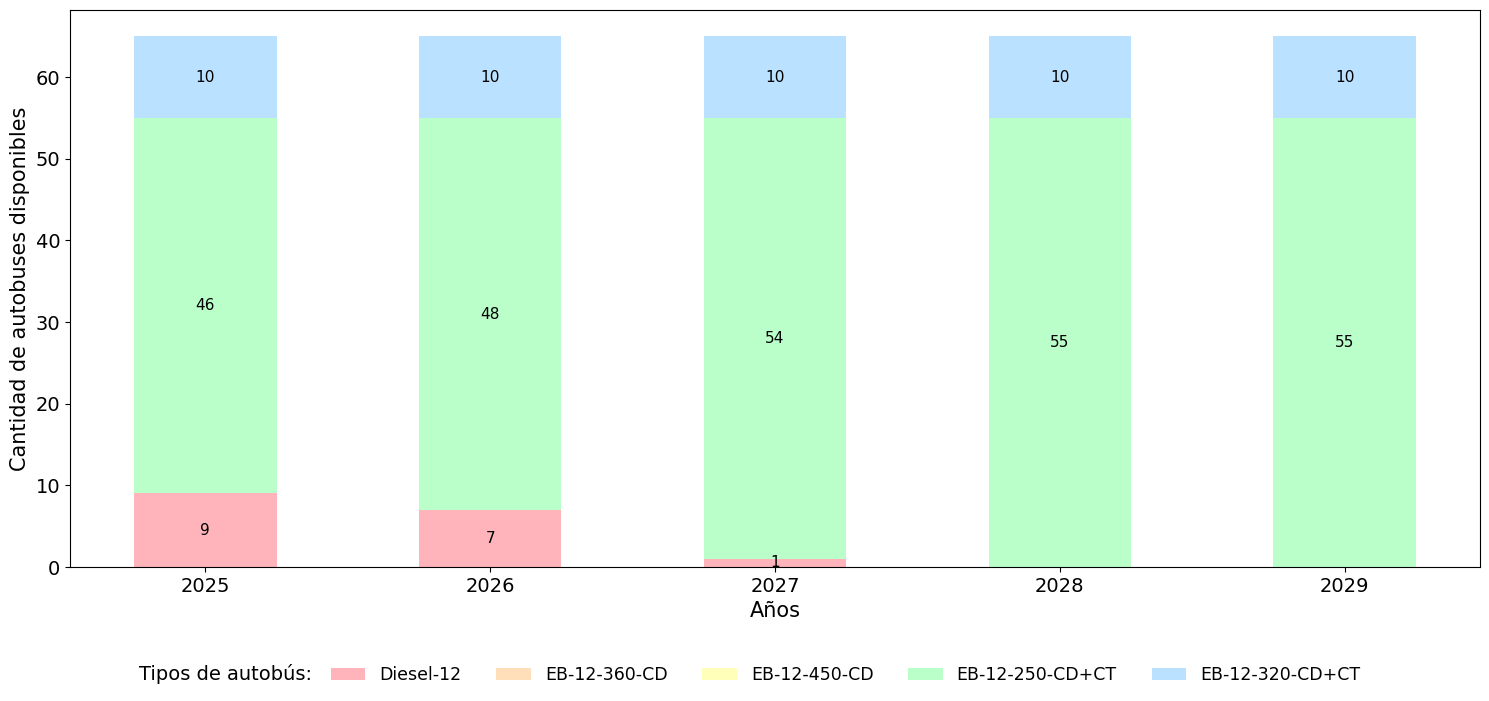

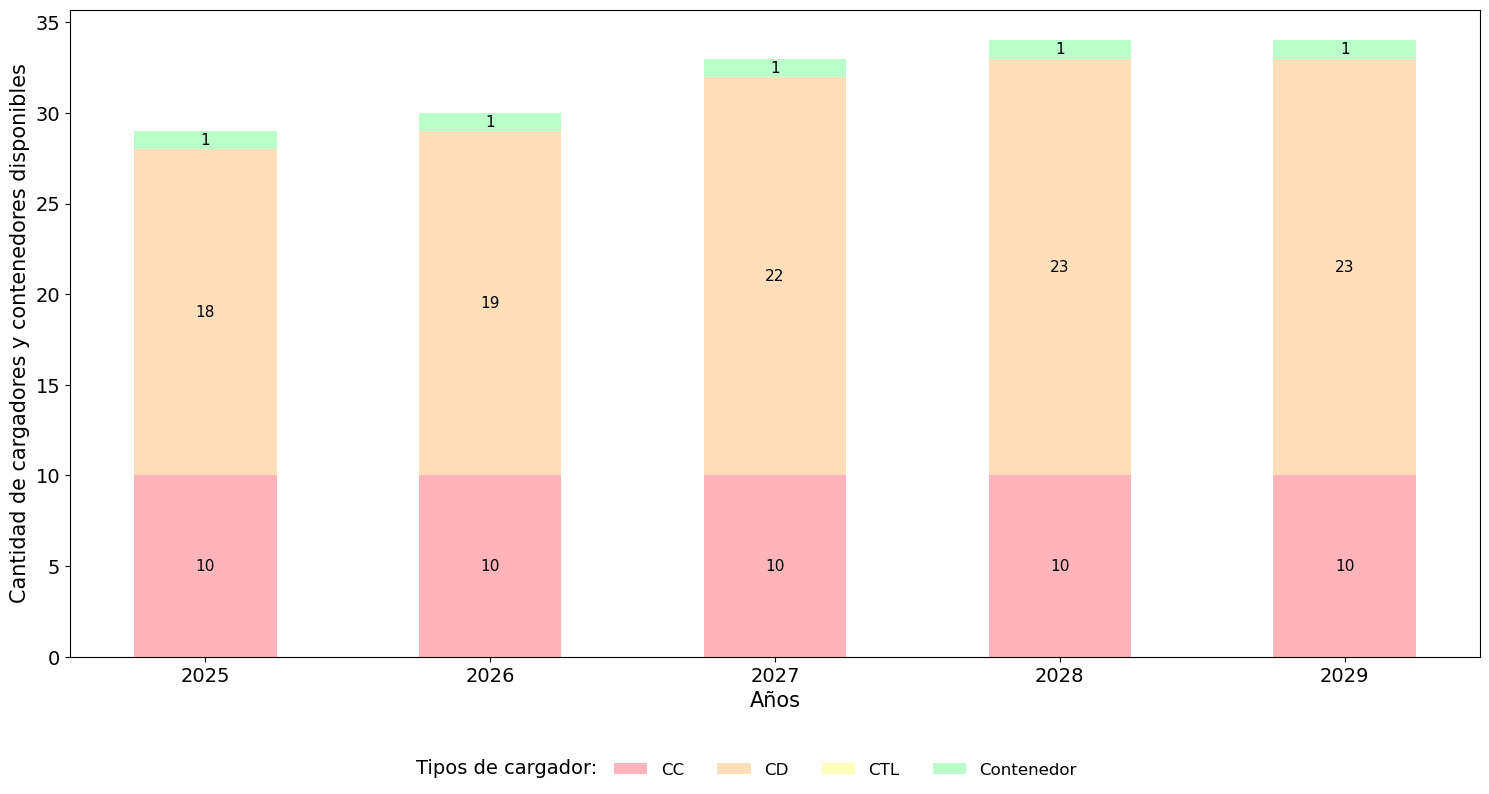

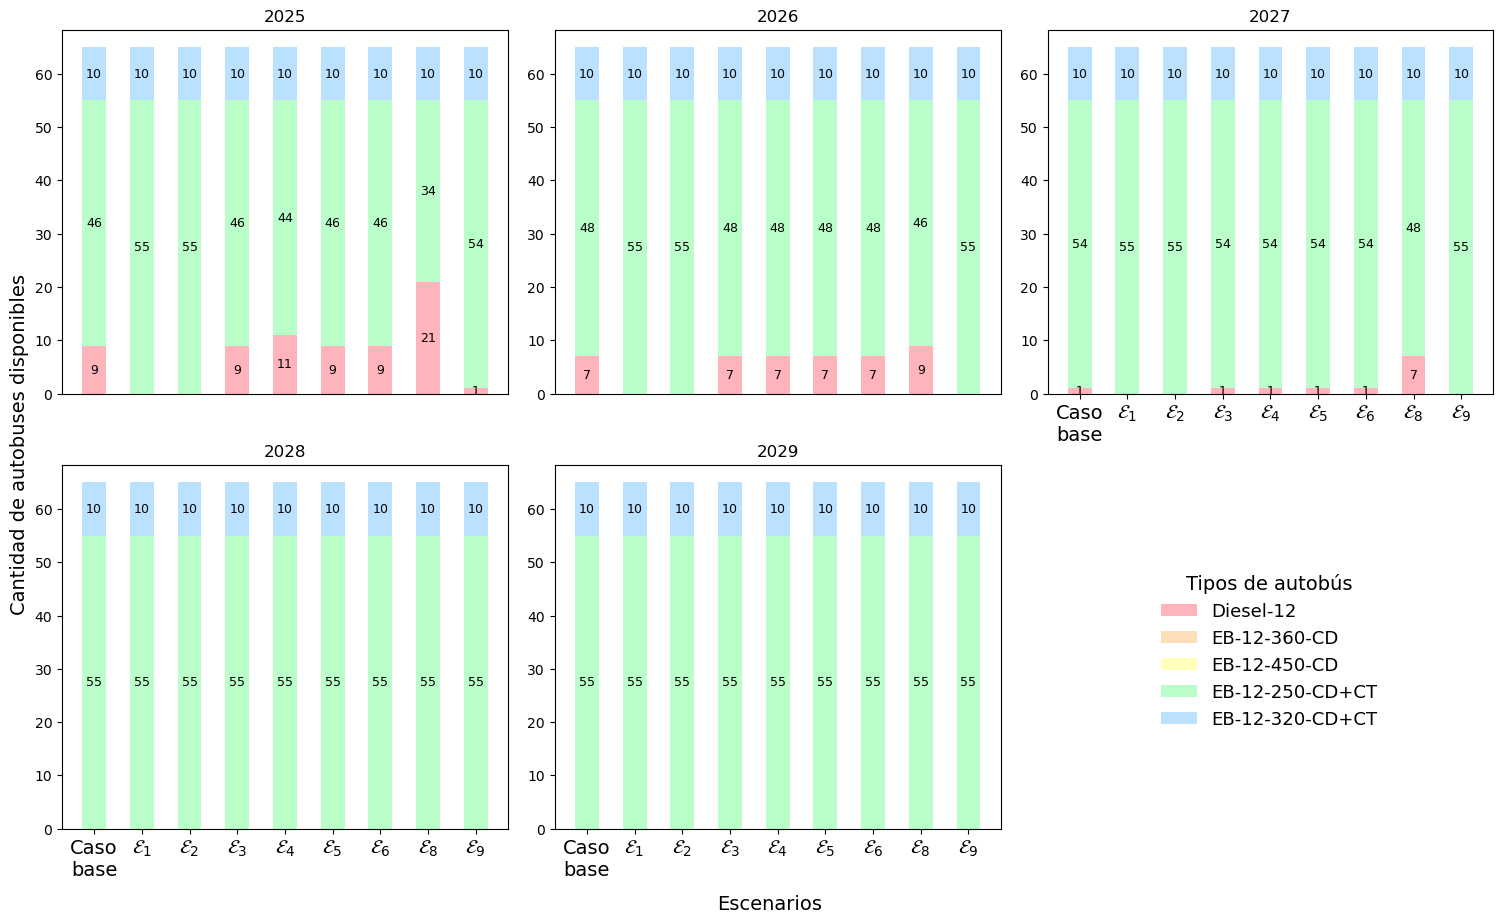

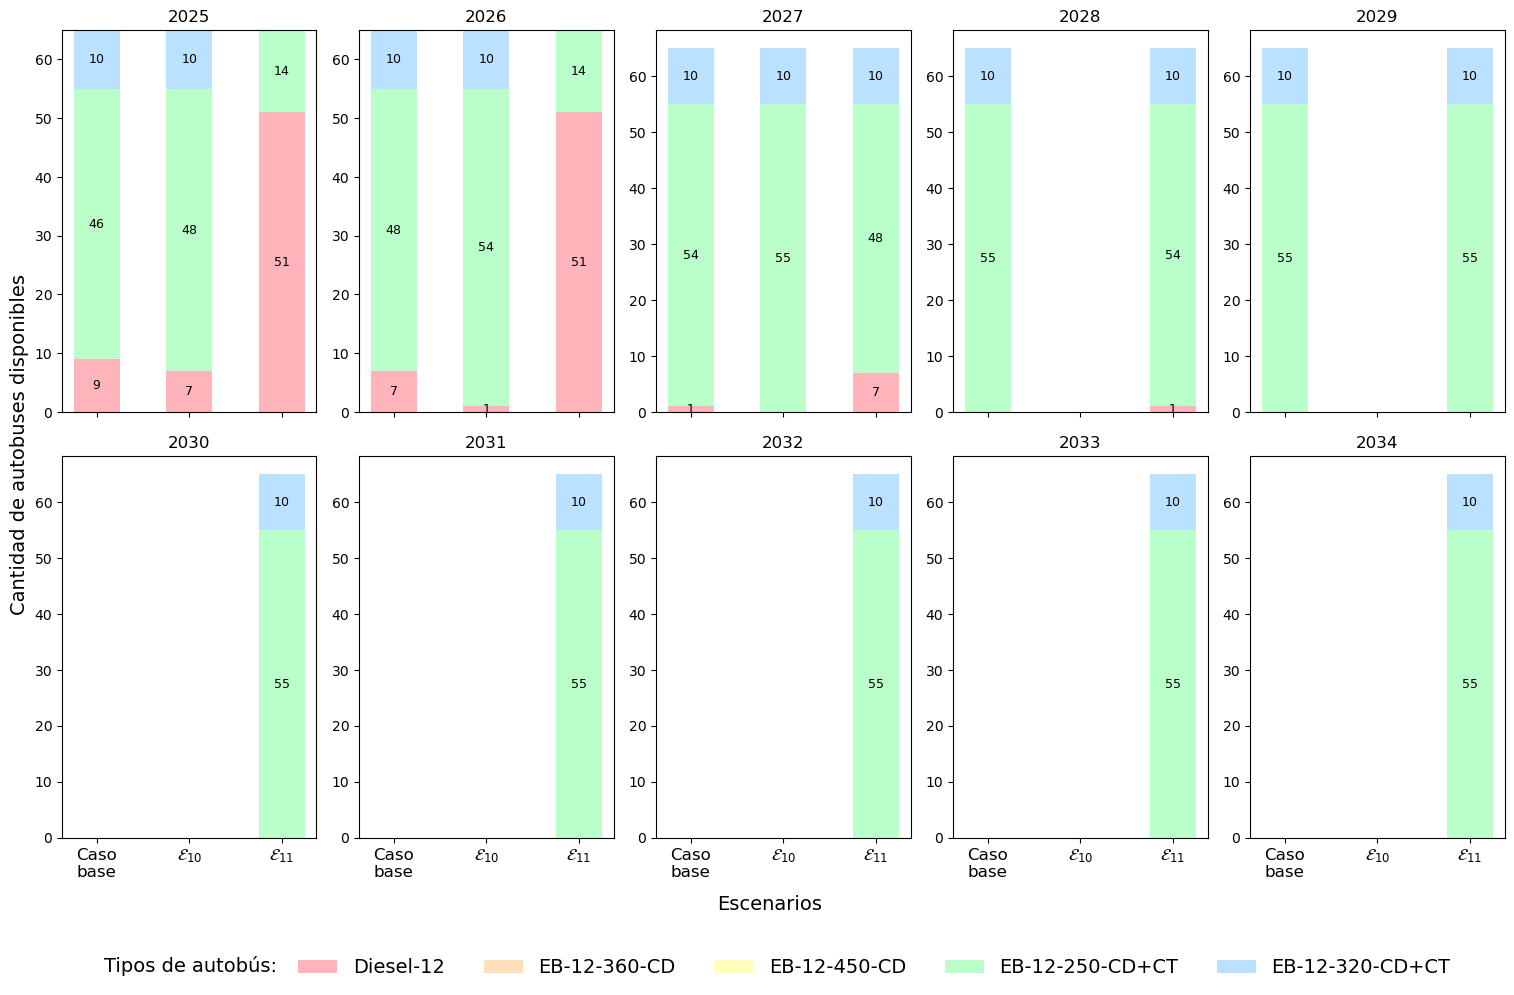

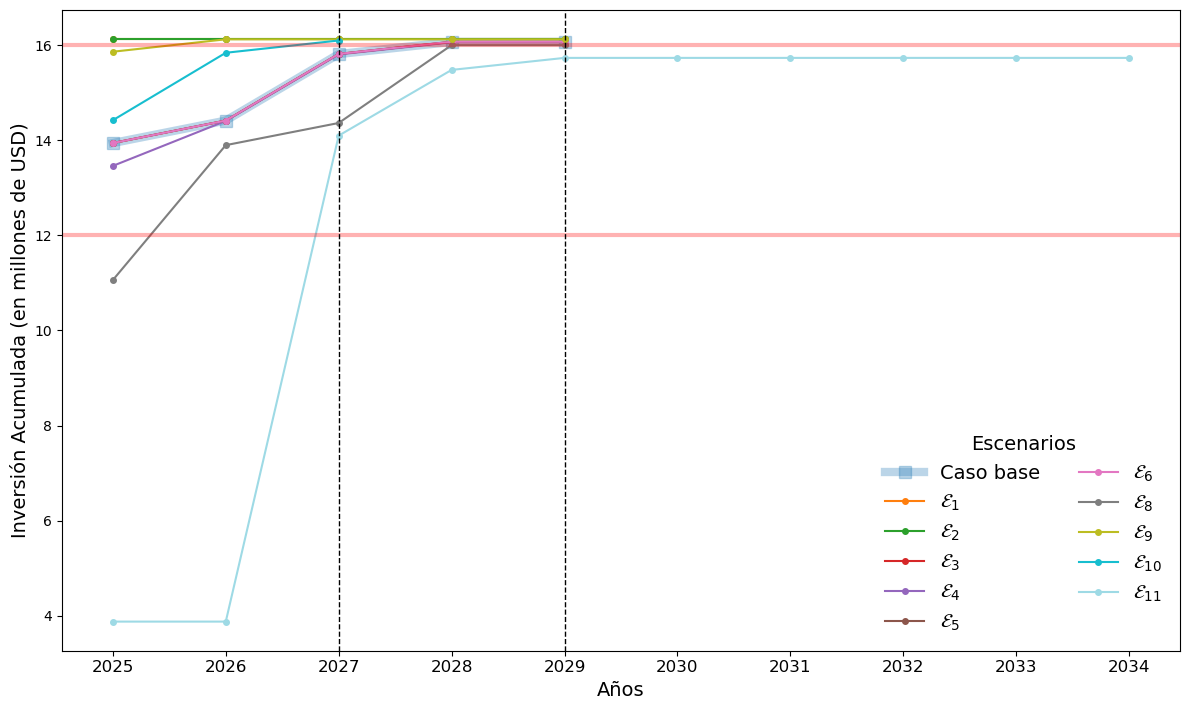

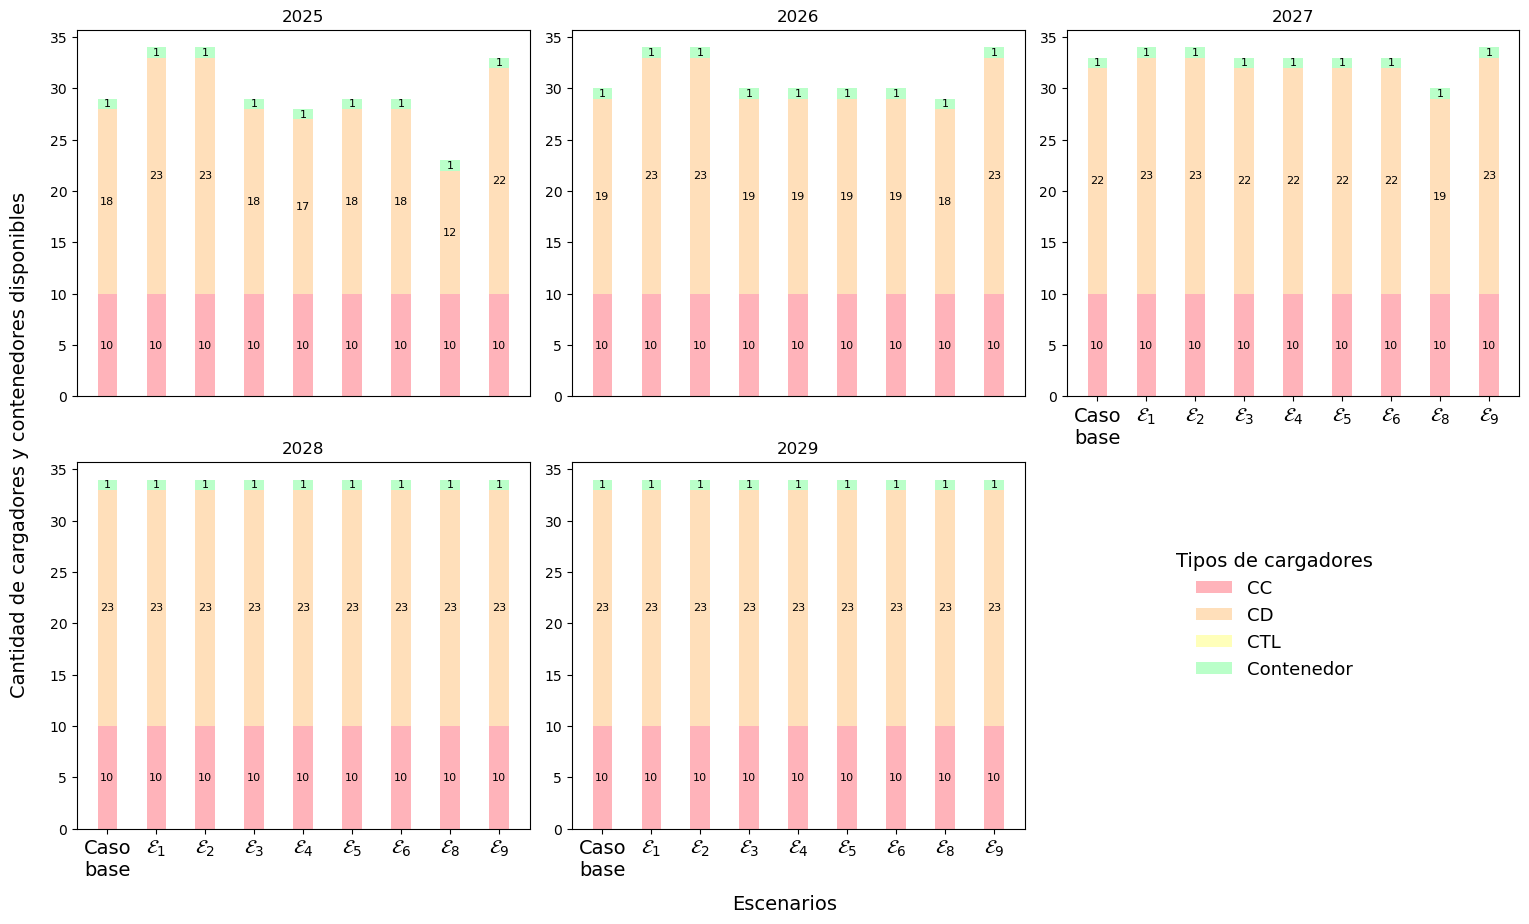

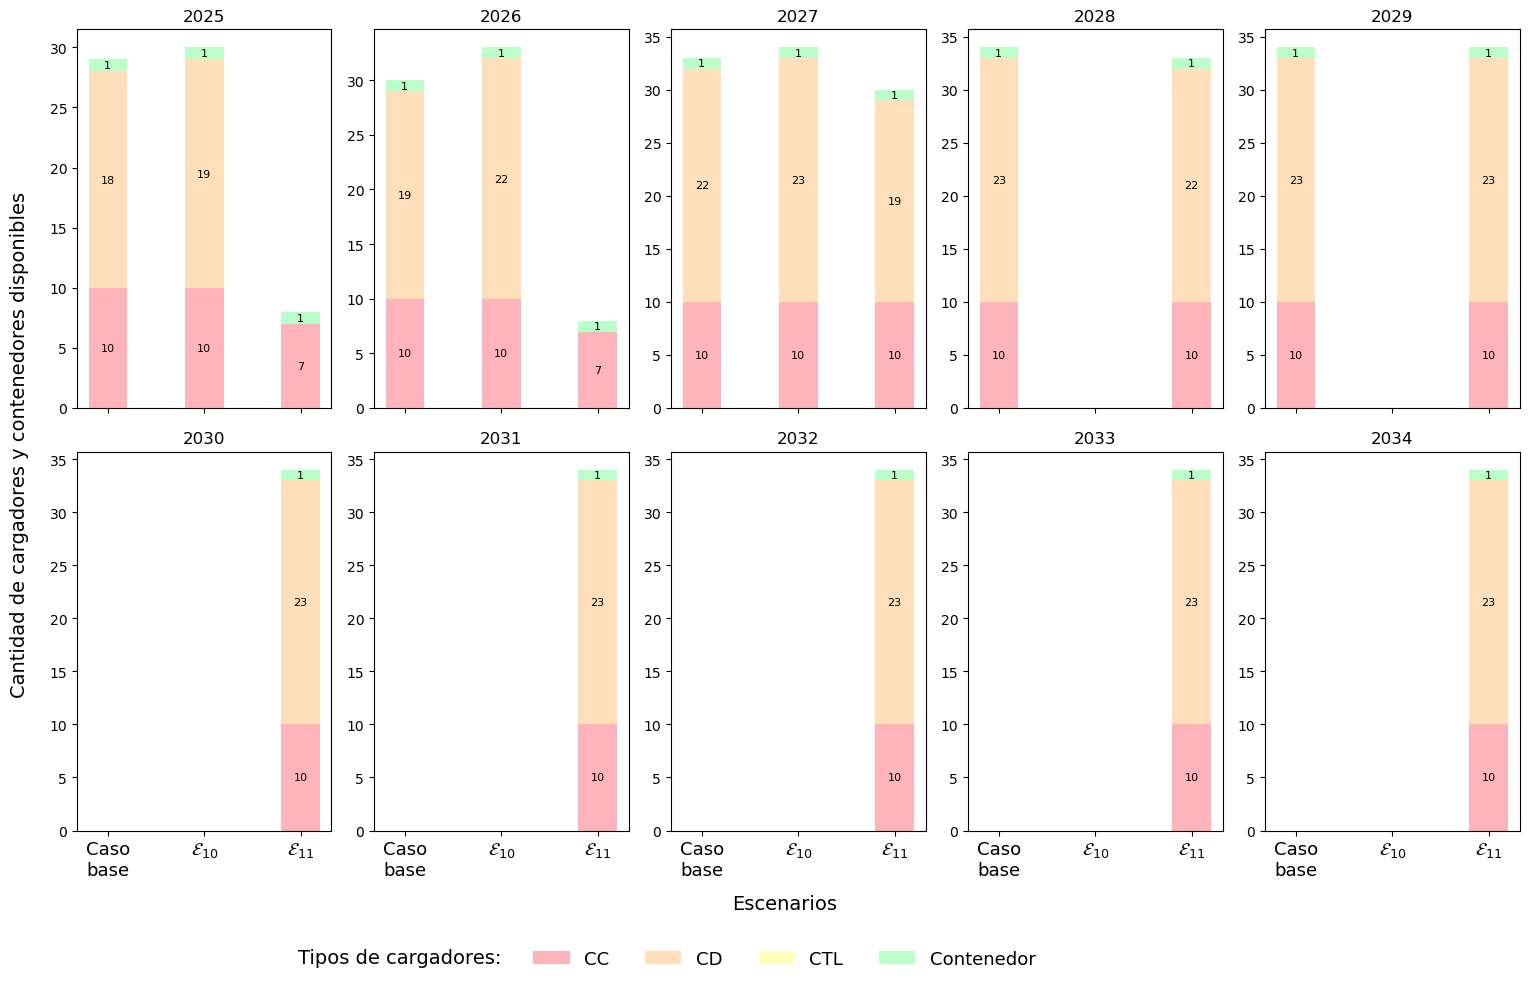

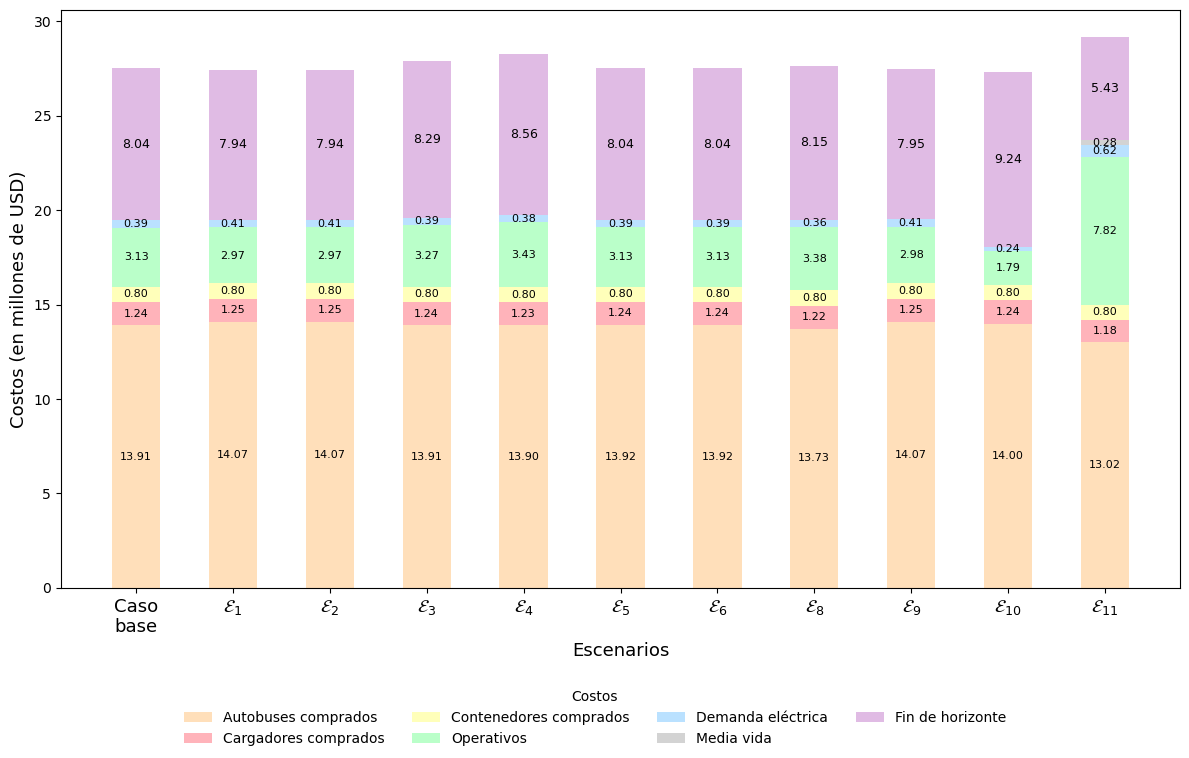

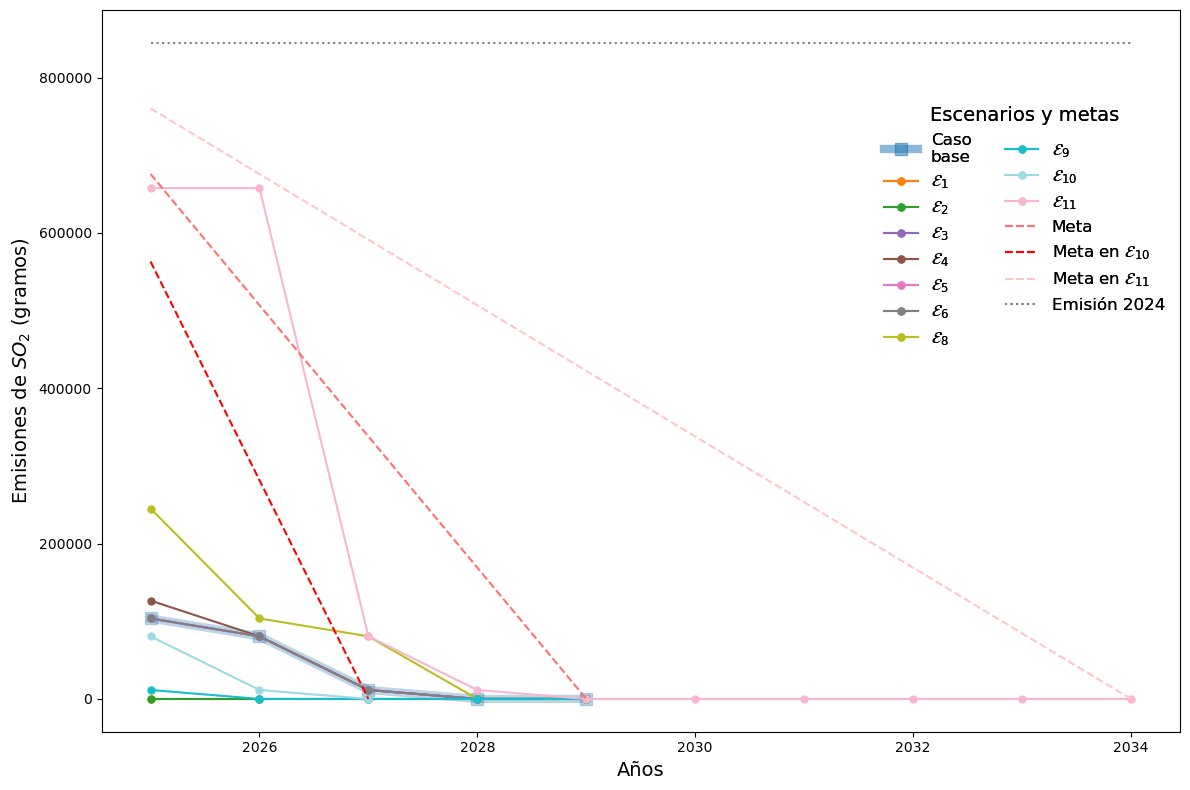

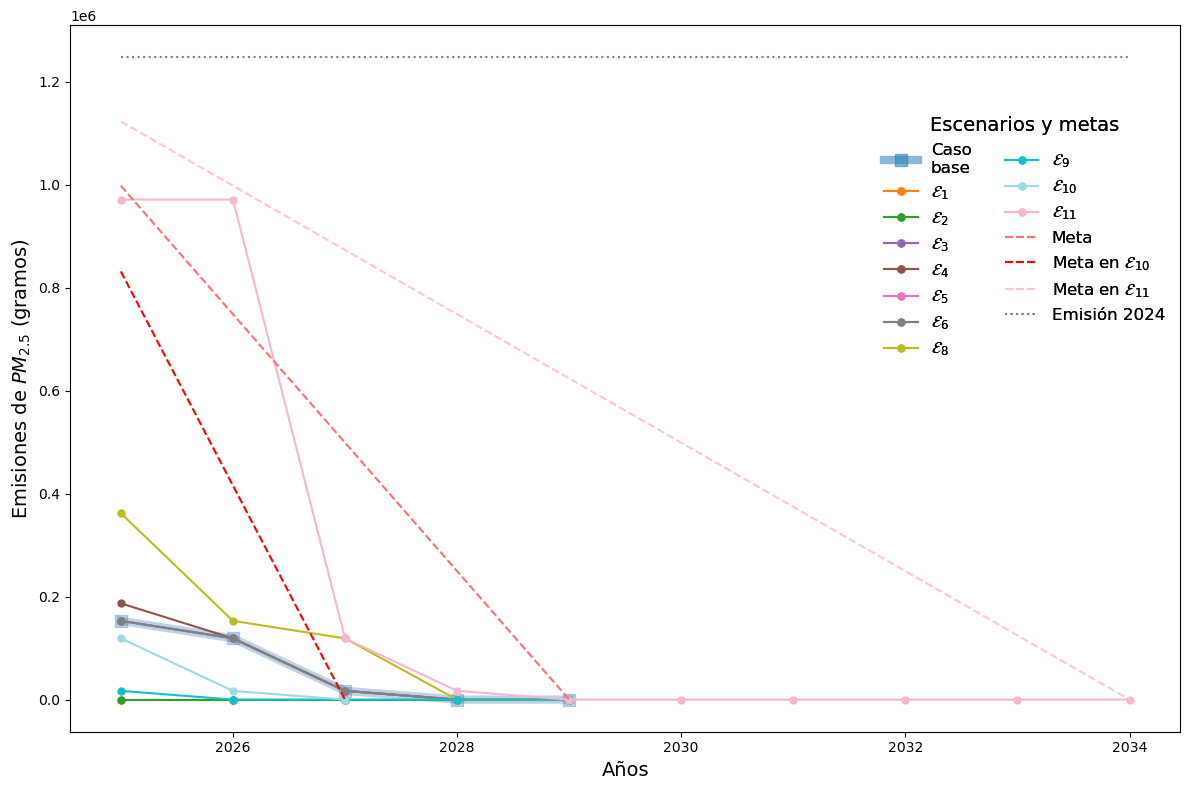

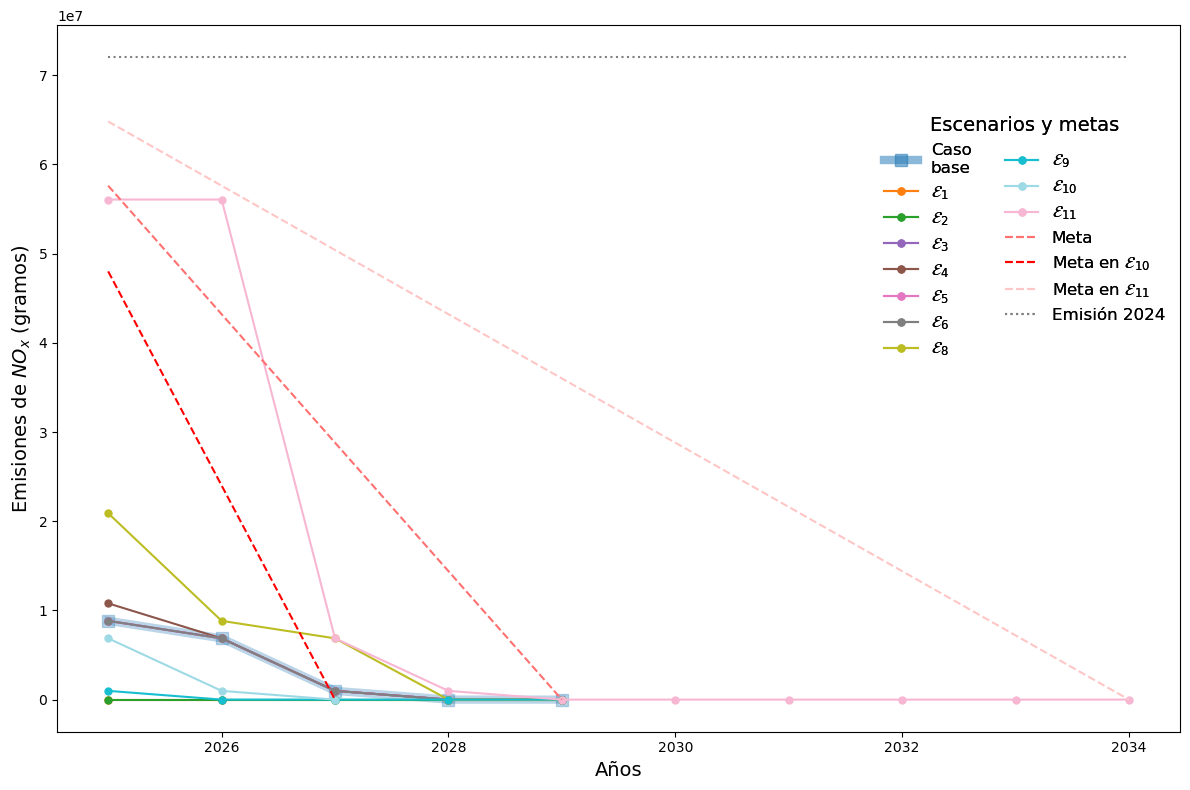

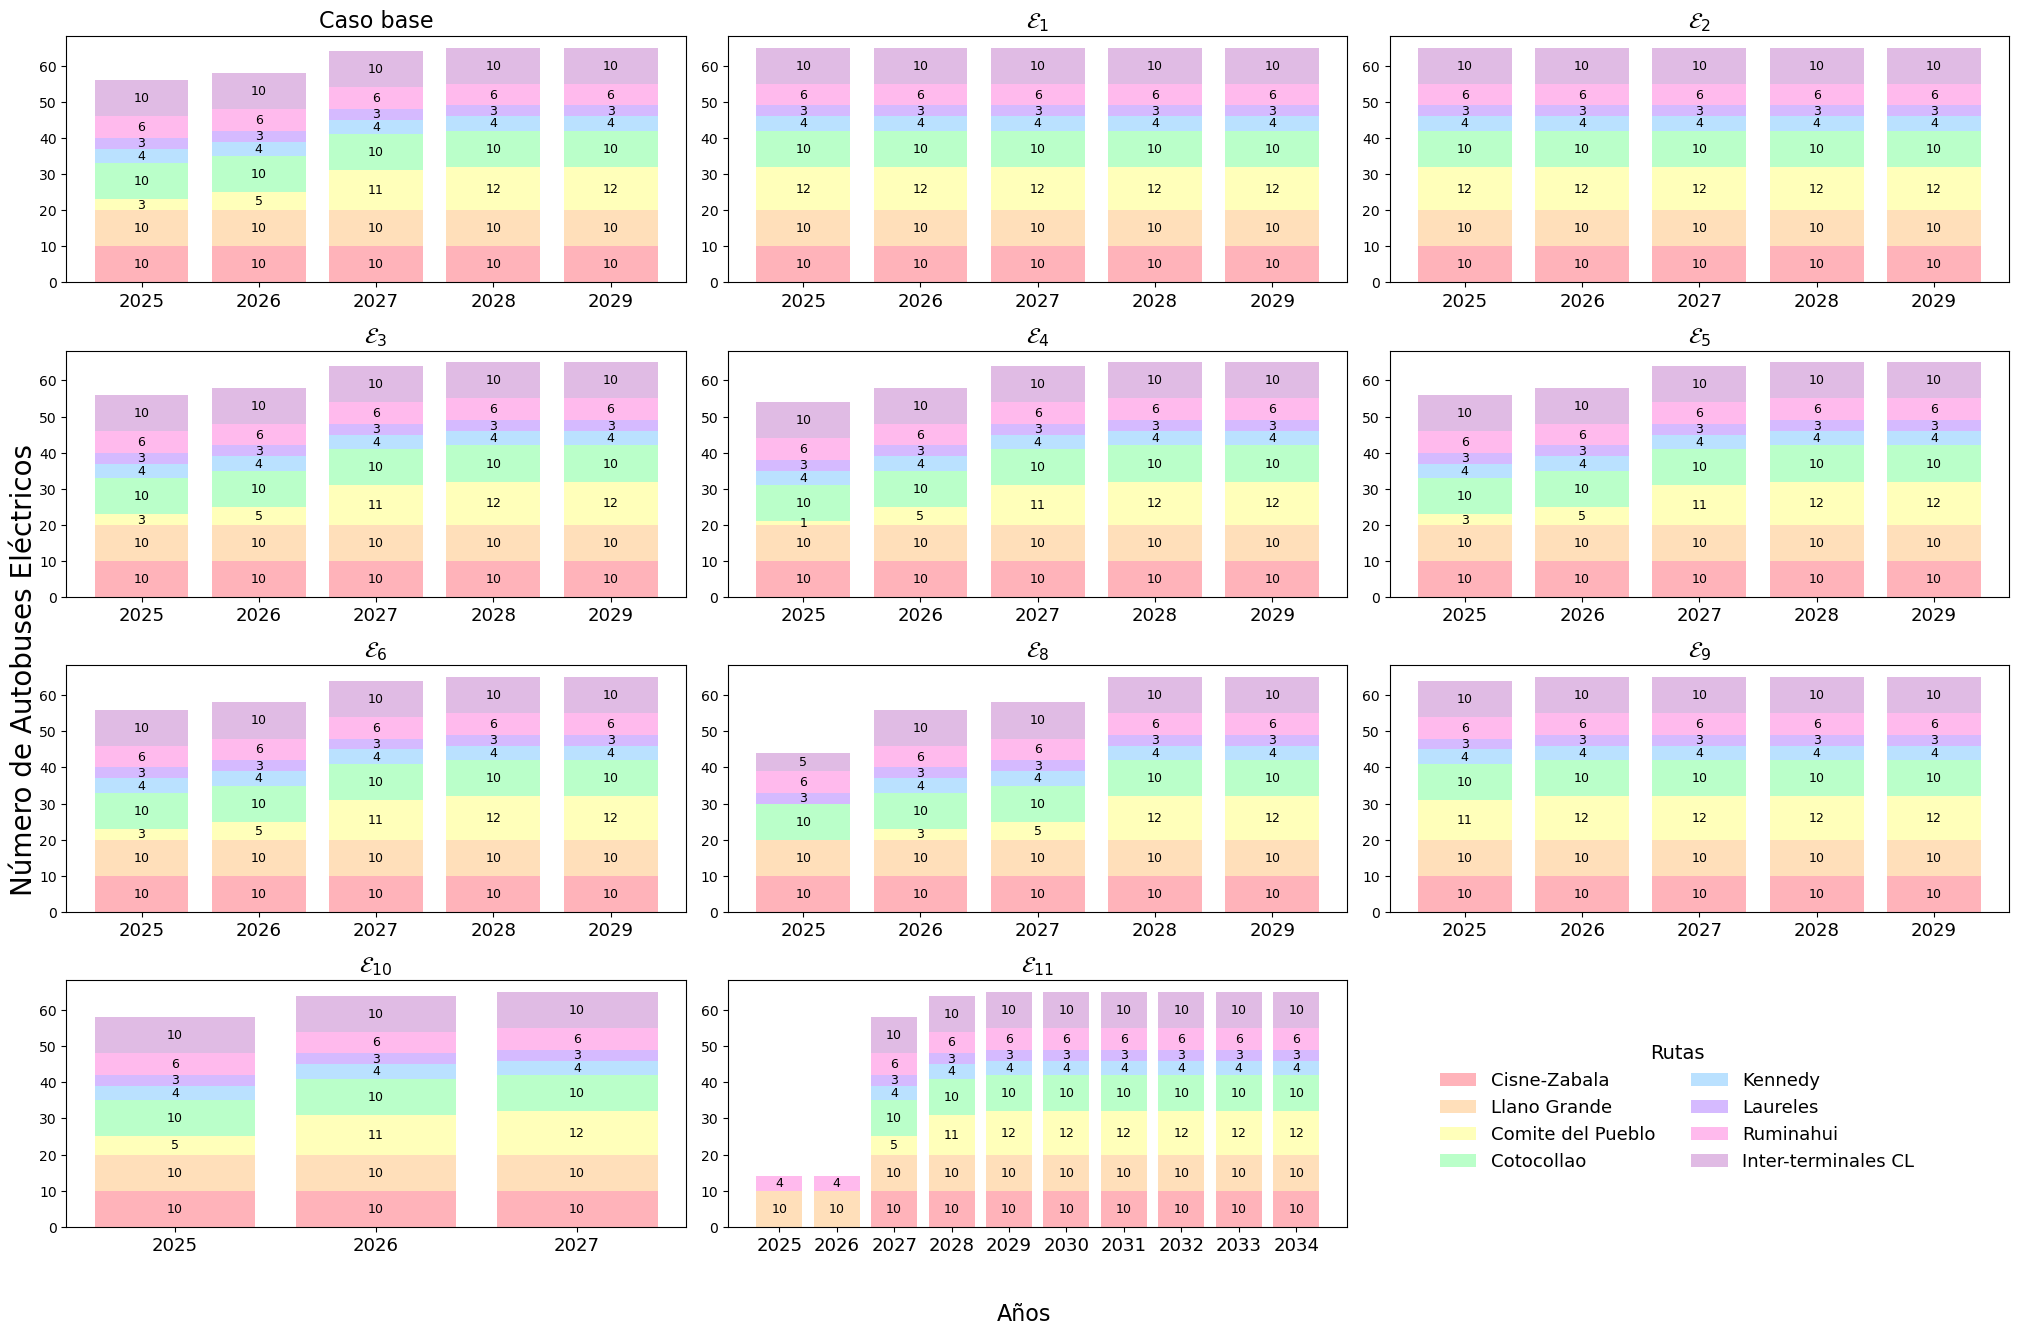

In [10]:
escenarios_0_10_11 = {i:j for i,j in informacion.items() if int(i.split(' ')[1]) in [0,10,11]}
escenarios_sin_10_11 = {i:j for i,j in informacion.items() if int(i.split(' ')[1]) not in [10,11]}
graficar_un_escenario(informacion, 'Autobuses Disponibles', 'Escenario 0', [2025,2026,2027,2028,2029])
graficar_un_escenario_cargadores_contenedores(informacion, 'Cargadores Disponibles', 'Contenedores Disponibles', 'Escenario 0', [2025,2026,2027,2028,2029])
graficar_autobuses_por_tipo_varios_anios_subplots(escenarios_sin_10_11, 'Autobuses Disponibles', [2025,2026,2027,2028,2029])
graficar_autobuses_por_tipo_varios_anios_subplots(escenarios_0_10_11, 'Autobuses Disponibles', list(range(2025,2035)))
graficar_inversion_acumulada_por_escenario(informacion, 'Inversion')
graficar_cargadores_y_contenedores_por_tipo_varios_anios_subplots(escenarios_sin_10_11, 'Cargadores Disponibles', 'Contenedores Disponibles', [2025, 2026, 2027, 2028, 2029])
graficar_cargadores_y_contenedores_por_tipo_varios_anios_subplots(escenarios_0_10_11, 'Cargadores Disponibles', 'Contenedores Disponibles', list(range(2025,2035)))
graficar_costos_por_tipo(informacion, 'Resumen')
graficar_emisiones_por_contaminante(informacion, 'Emisiones', 'SO2')
graficar_emisiones_por_contaminante(informacion, 'Emisiones', 'PM25')
graficar_emisiones_por_contaminante(informacion, 'Emisiones', 'NOX')
graficar_asignacion_autobuses_por_ruta(informacion, 'Autobuses electricos por ruta')

In [13]:
# para calcular la comparativa hay que correr dos veces el codigo, 
# en la segunda se debe fijar el caso base e ir guardando la información en estos dos diccionarios
# en la segunda corrida solo elegir los escenarios que no son infactibles con las decisiones del Caso Base [0,1,2,3,4,5,6,9,11]

#informacion_CB_fijada = {i:j for i,j in informacion.items()}
# del informacion
#informacion_original = {i:j for i,j in informacion.items()}

#graficar_costos_comparativos(informacion_original, informacion_CB, 'Resumen')


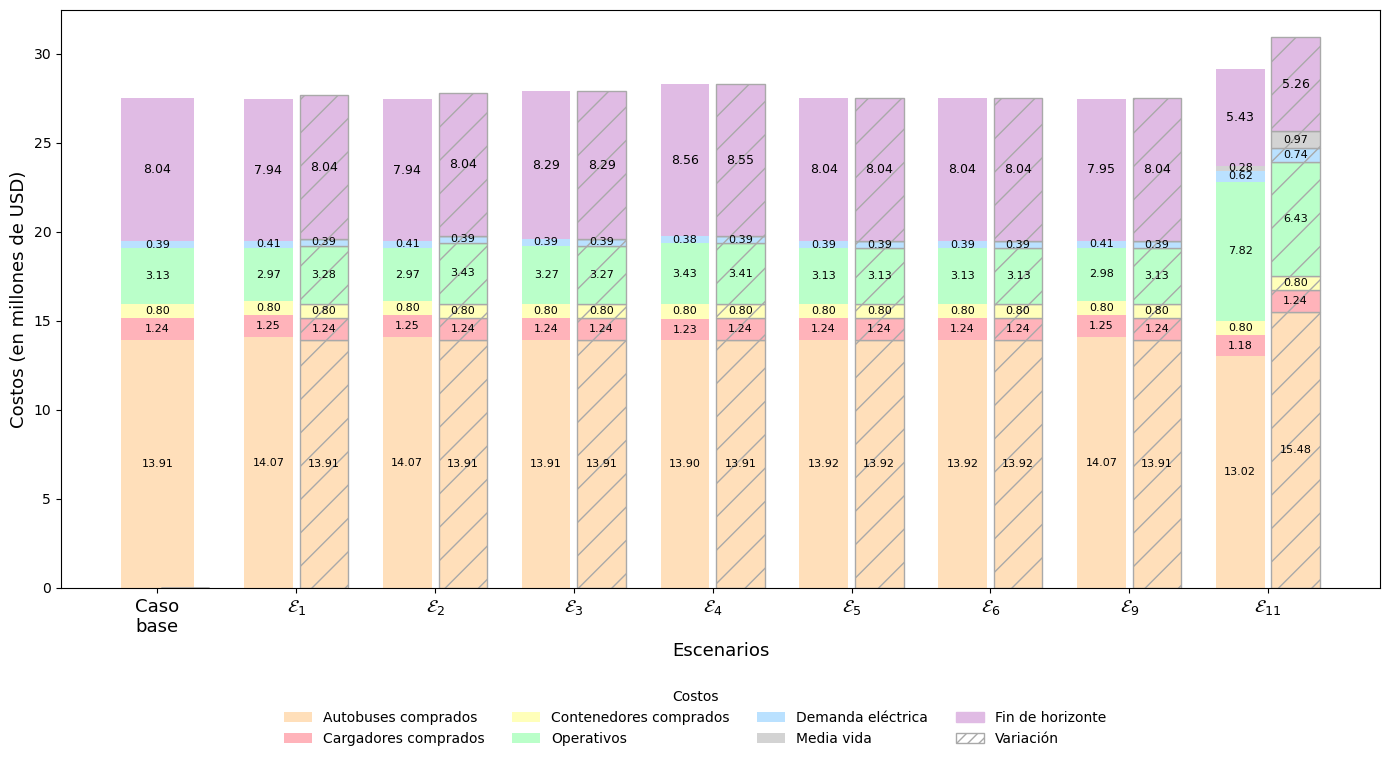